# **APPROACH 1: FINE-TUNING A PRE-TRAINED MODEL**

In [ ]:
# Implementation of both approaches for predicting star ratings from review text
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Install required packages if they're not already installed
try:
    import transformers
except ImportError:
    print("Installing transformers package...")
    !pip install transformers
    import transformers

# Print versions for debugging
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

PyTorch version: 2.6.0+cu124
Transformers version: 4.51.3


In [ ]:
# Configuration
PROCESSED_FILE_PATH = r"processed_electronics_reviews_openrouter_threaded.jsonl"
# Limit reviews for faster execution
MAX_REVIEWS_TO_LOAD = 5000  # Smaller number for fine-tuning

print(f"Loading data from {PROCESSED_FILE_PATH}...")
if not os.path.exists(PROCESSED_FILE_PATH):
    raise FileNotFoundError(f"Input file not found: {PROCESSED_FILE_PATH}")

# Load data
all_data = []
with open(PROCESSED_FILE_PATH, 'r', encoding='utf-8') as f:
    for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
        if MAX_REVIEWS_TO_LOAD is not None and i >= MAX_REVIEWS_TO_LOAD:
            print(f"\nReached limit of {MAX_REVIEWS_TO_LOAD} reviews.")
            break
        try:
            all_data.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Warning: Skipping invalid JSON on line {i+1}")

if not all_data:
    raise ValueError("No valid data loaded.")

df = pd.json_normalize(all_data, sep='_')
print(f"Loaded {len(df)} total entries into DataFrame.")

# Data exploration and cleaning
print("Available columns:", df.columns.tolist())

# Check if required columns exist
if 'rating' not in df.columns:
    possible_rating_cols = [col for col in df.columns if 'rat' in col.lower()]
    if possible_rating_cols:
        df['rating'] = df[possible_rating_cols[0]]
    else:
        raise ValueError("No rating column found")

# Combine title and text
if 'title' in df.columns and 'text' in df.columns:
    df['input_text'] = df['title'].fillna('') + ' - ' + df['text'].fillna('')
elif 'text' in df.columns:
    df['input_text'] = df['text'].fillna('')
else:
    raise ValueError("No text column found")

# Basic filtering
filter_condition = df['input_text'].str.strip().astype(bool)
filter_condition &= df['rating'].notna()

# Error columns - be more lenient
error_cols = [col for col in ['error', 'llm_analysis_error'] if col in df.columns]
if error_cols:
    for col in error_cols:
        # Only filter out rows with actual error content
        has_error = df[col].notna() & (df[col] != '')
        filter_condition &= ~has_error

df_valid = df[filter_condition].copy()
print(f"After filtering: {len(df_valid)} valid rows")

if df_valid.empty or len(df_valid) < 100:
    # Try minimal filtering if needed
    filter_condition = df['input_text'].str.strip().astype(bool)
    filter_condition &= df['rating'].notna()
    df_valid = df[filter_condition].copy()
    print(f"Minimal filtering resulted in {len(df_valid)} rows")

# Ensure rating is numeric
df_valid['rating'] = pd.to_numeric(df_valid['rating'], errors='coerce')
df_valid.dropna(subset=['rating'], inplace=True)

# Normalize ratings to 1-5 if needed
min_rating = df_valid['rating'].min()
max_rating = df_valid['rating'].max()
print(f"Rating range: {min_rating} to {max_rating}")

if max_rating > 5.5 or min_rating < 0.5:
    print("Normalizing ratings to 1-5 scale...")
    df_valid['rating'] = 1 + (df_valid['rating'] - min_rating) * 4 / (max_rating - min_rating)

# Print rating distribution
print("\nRating distribution:")
print(df_valid['rating'].value_counts().sort_index())

# Prepare features and target
X = df_valid['input_text'].tolist()
y = df_valid['rating'].values

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

Loading data from processed_electronics_reviews_openrouter_threaded.jsonl...


Reading JSONL: 0it [00:00, ?it/s]


Reached limit of 5000 reviews.
Loaded 5000 total entries into DataFrame.
Available columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'processed_line', 'processing_timestamp', 'llm_model_used', 'llm_analysis_error', 'llm_analysis_details']
After filtering: 0 valid rows
Minimal filtering resulted in 5000 rows
Rating range: 1.0 to 5.0

Rating distribution:
rating
1.0     159
2.0      57
3.0     120
4.0     479
5.0    4185
Name: count, dtype: int64
Training set size: 4000
Test set size: 1000


In [ ]:
!pip install evaluate

In [ ]:
!pip install --upgrade transformers

In [ ]:
# ----- 2. MODEL SETUP -----

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and model - using distilbert for efficiency
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Load model for regression
print("Loading model for regression...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=1  # Key change for regression!
).to(device)

# Create a custom dataset class for regression
class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# Prepare datasets with a shorter max_length for efficiency
print("Preparing datasets...")
train_dataset = RegressionDataset(X_train_text, y_train, tokenizer, max_length=128)
test_dataset = RegressionDataset(X_test_text, y_test, tokenizer, max_length=128)

Using device: cpu
Loading model for regression...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing datasets...


In [ ]:
# ----- 3. TRAINING -----

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.MSELoss()

# Training loop
num_epochs = 3
print(f"\nTraining for {num_epochs} epochs...")

# To store metrics
train_losses = []
val_metrics = {'epoch': [], 'mae': [], 'rmse': []}


# Import DataLoader
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Adjust batch_size as needed
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        # Get the logits from the outputs
        logits = outputs.logits
        # Calculate the loss using the logits and labels
        loss = criterion(logits.squeeze(-1), batch['labels'])


        # ***Get the logits (predictions) from the outputs***
        logits = outputs.logits

        # ***Calculate the loss using the logits and labels***
        loss = criterion(logits.squeeze(-1), batch['labels'])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            # Removed the line causing the error: s

            # Store predictions and labels
            # Access logits and move to cpu before converting to numpy
            all_preds.extend(outputs.logits.cpu().detach().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    # Calculate metrics
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))

    val_metrics['epoch'].append(epoch + 1)
    val_metrics['mae'].append(mae)
    val_metrics['rmse'].append(rmse)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val MAE: {mae:.4f}, Val RMSE: {rmse:.4f}")


Training for 3 epochs...


Epoch 1/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/3 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.1976, Val MAE: 0.2149, Val RMSE: 0.4421


Epoch 2/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/3 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.1488, Val MAE: 0.2071, Val RMSE: 0.4383


Epoch 3/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/3 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.1295, Val MAE: 0.2617, Val RMSE: 0.4610


Final Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]


Final Evaluation Results:
  MAE: 0.2617
  RMSE: 0.4610
  R²: 0.6907


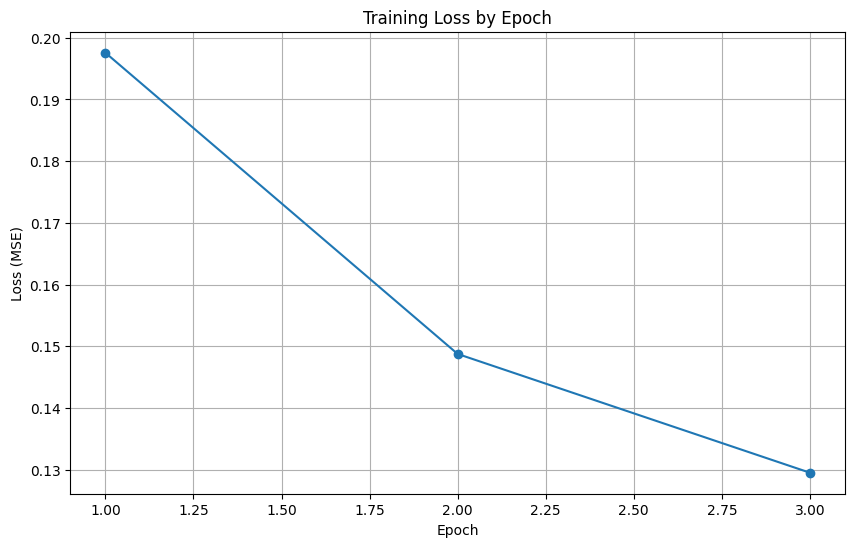

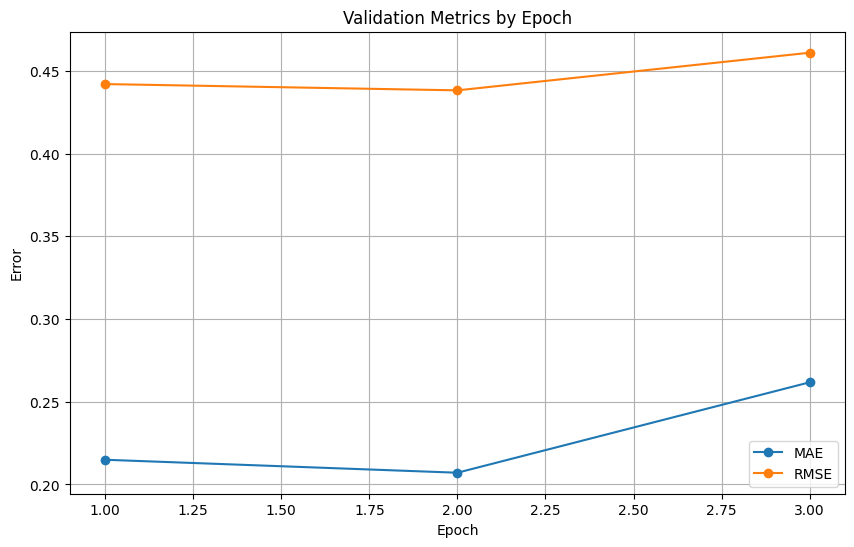

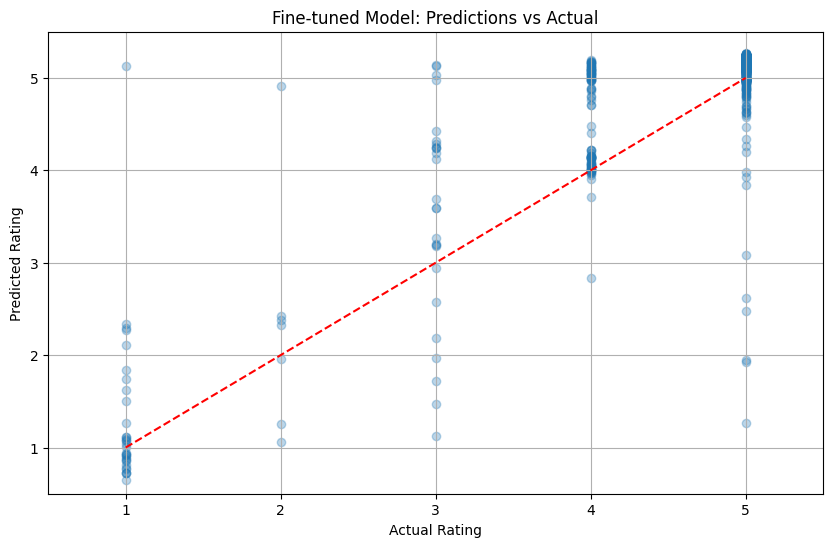


----- ERROR ANALYSIS -----

Worst Predictions (Highest Absolute Error):

Actual Rating: 1.0, Predicted: 5.13, Error: -4.13
Review Text: Speaker - Speaker dosent work...

Actual Rating: 5.0, Predicted: 1.26, Error: 3.74
Review Text: Poor - Poor...

Actual Rating: 5.0, Predicted: 1.92, Error: 3.08
Review Text: Micro usb is cheap - Last maybe a year...

Actual Rating: 5.0, Predicted: 1.95, Error: 3.05
Review Text: Not needed - Not needed...

Actual Rating: 2.0, Predicted: 4.91, Error: -2.91
Review Text: Too many ads - Too many ads...

----- APPROACH 1 SUMMARY -----
1. We fine-tuned a DistilBERT model for regression to predict Amazon review ratings
2. We used a custom implementation without HuggingFace Trainer to avoid compatibility issues
3. Performance metrics:
   - Mean Absolute Error (MAE): 0.2617
   - Root Mean Squared Error (RMSE): 0.4610
   - R-squared (R²): 0.6907
4. The model can predict star ratings with an average error of 0.26 stars
5. This approach adapts the pre-trained lang

In [ ]:
# ----- 4. EVALUATION -----

# Final evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Evaluation"):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Store predictions and labels
        all_preds.extend(outputs.logits.cpu().detach().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Calculate metrics
mae = mean_absolute_error(all_labels, all_preds)
rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
r2 = r2_score(all_labels, all_preds)

print("\nFinal Evaluation Results:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²: {r2:.4f}")

# ----- 5. VISUALIZATION -----

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

# Plot validation metrics
plt.figure(figsize=(10, 6))
plt.plot(val_metrics['epoch'], val_metrics['mae'], marker='o', label='MAE')
plt.plot(val_metrics['epoch'], val_metrics['rmse'], marker='o', label='RMSE')
plt.title('Validation Metrics by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_preds, alpha=0.3)
plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
plt.title('Fine-tuned Model: Predictions vs Actual')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.grid(True)
plt.show()

# ----- 6. ERROR ANALYSIS -----

# Create dataframe with predictions
error_df = pd.DataFrame({
    'Actual': all_labels,
    'Predicted': [p[0] for p in all_preds],  # Flatten predictions
    'Error': np.array(all_labels) - np.array([p[0] for p in all_preds]),  # Flatten predictions here as well
    'Abs_Error': np.abs(np.array(all_labels) - np.array([p[0] for p in all_preds])),  # Flatten predictions here as well
    'Text': X_test_text
})

# Look at examples with high error
print("\n----- ERROR ANALYSIS -----")
print("\nWorst Predictions (Highest Absolute Error):")
worst_predictions = error_df.sort_values('Abs_Error', ascending=False).head(5)
for i, row in worst_predictions.iterrows():
    print(f"\nActual Rating: {row['Actual']}, Predicted: {row['Predicted']:.2f}, Error: {row['Error']:.2f}")
    print(f"Review Text: {row['Text'][:150]}...")  # Show first 150 chars

# ----- 7. SUMMARY -----

print("\n----- APPROACH 1 SUMMARY -----")
print("1. We fine-tuned a DistilBERT model for regression to predict Amazon review ratings")
print("2. We used a custom implementation without HuggingFace Trainer to avoid compatibility issues")
print(f"3. Performance metrics:")
print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
print(f"   - Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   - R-squared (R²): {r2:.4f}")
print(f"4. The model can predict star ratings with an average error of {mae:.2f} stars")
print("5. This approach adapts the pre-trained language model to perform regression")
print("6. Key advantages:")
print("   - Leverages pre-trained language understanding")
print("   - Can capture complex relationships between text and ratings")
print("   - End-to-end training")

# Optional: Save the model
print("\nTo save this model for future use:")
print("```python")
print("# Save model")
print("torch.save(model.state_dict(), 'distilbert_regression_model.pt')")
print("# Save tokenizer")
print("tokenizer.save_pretrained('tokenizer')")
print("```")

# **Approach 2: Feature Extraction + Traditional ML**

Loading data from processed_electronics_reviews_openrouter_threaded.jsonl...


0it [00:00, ?it/s]

Reached limit of 10000 reviews.
Loaded 10000 total entries into DataFrame.
Available columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'llm_analysis', 'processed_line', 'processing_timestamp', 'llm_model_used']
Valid rows after filtering: 10000
Rows after ensuring numeric ratings: 10000
Rating range: 1.0 to 5.0


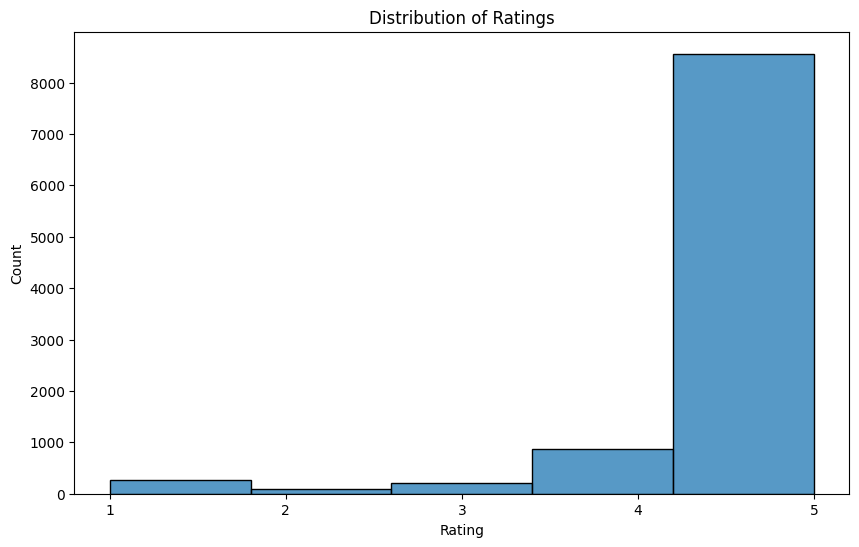

Training set size: 8000
Test set size: 2000

Extracting features with TF-IDF...
TF-IDF feature matrix shape: (8000, 1969)

Training regression models...

Training Ridge Regression...
Ridge Regression Results:
  Mean Absolute Error (MAE): 0.3273
  Root Mean Squared Error (RMSE): 0.6363
  R-squared (R²): 0.2750


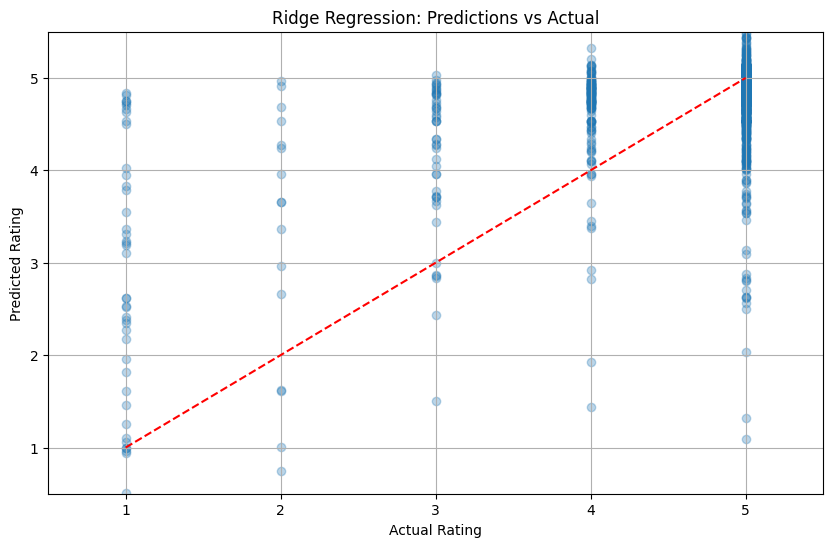


Training Gradient Boosting...
Gradient Boosting Results:
  Mean Absolute Error (MAE): 0.3451
  Root Mean Squared Error (RMSE): 0.6093
  R-squared (R²): 0.3353


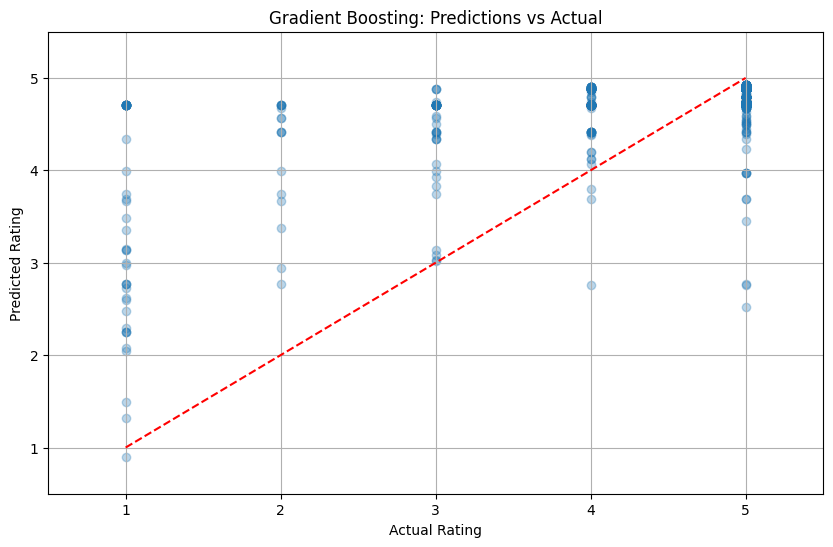


Model Comparison:
               Model       MAE      RMSE        R²
0   Ridge Regression  0.327331  0.636273  0.275040
1  Gradient Boosting  0.345058  0.609261  0.335289


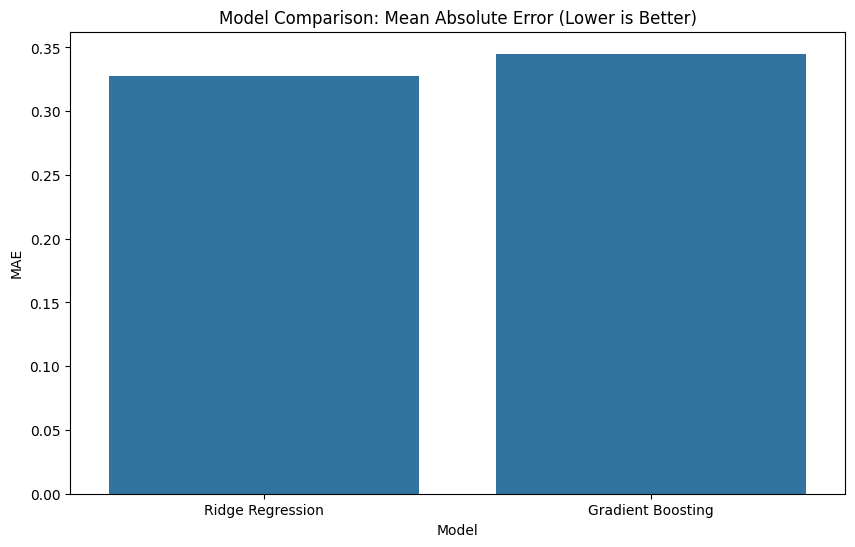


Best model: Ridge Regression
MAE: 0.3273 (average error in stars)
RMSE: 0.6363
R²: 0.2750

Worst Predictions (Highest Absolute Error):

Actual Rating: 5.0, Predicted: -1.71, Error: 6.71
Review Text: Get it! Wont disappoint!! - sounds great!...

Actual Rating: 2.0, Predicted: 6.14, Error: -4.14
Review Text: Two Stars - hums when charging...

Actual Rating: 5.0, Predicted: 1.09, Error: 3.91
Review Text: Great until my charging port broke so its perminently dead - Live out loud...

Actual Rating: 1.0, Predicted: 4.84, Error: -3.84
Review Text: Na - Na...

Actual Rating: 1.0, Predicted: 4.82, Error: -3.82
Review Text: Not good itsm - Quality is not good...

----- SUMMARY -----
1. We implemented Approach 2: Feature Extraction + Traditional ML
2. Best model: Ridge Regression with MAE of 0.3273
3. This means our predictions are off by approximately 0.33 stars on average
4. The feature extraction approach efficiently converts text to numerical features
5. Traditional ML models can then learn 

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer  # Import FunctionTransformer here
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Step 1: Load and Prepare Data ---

# Set file path
PROCESSED_FILE_PATH = "processed_electronics_reviews_openrouter_threaded.jsonl"

# Option to limit reviews for faster execution
MAX_REVIEWS_TO_LOAD = 10000  # Set to None to use all reviews

print(f"Loading data from {PROCESSED_FILE_PATH}...")

# Load data from JSONL file
all_data = []
with open(PROCESSED_FILE_PATH, 'r', encoding='utf-8') as f:
    for i, line in enumerate(tqdm(f)):
        if MAX_REVIEWS_TO_LOAD is not None and i >= MAX_REVIEWS_TO_LOAD:
            print(f"Reached limit of {MAX_REVIEWS_TO_LOAD} reviews.")
            break
        try:
            all_data.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Warning: Skipping invalid JSON on line {i+1}")

# Convert to DataFrame
df = pd.DataFrame(all_data)
print(f"Loaded {len(df)} total entries into DataFrame.")

# Check available columns
print("Available columns:", df.columns.tolist())

# Check if rating column exists
if 'rating' not in df.columns:
    possible_rating_cols = [col for col in df.columns if 'rat' in col.lower()]
    if possible_rating_cols:
        df['rating'] = df[possible_rating_cols[0]]
    else:
        raise ValueError("No rating column found!")

# Combine title and text if both exist
if 'title' in df.columns and 'text' in df.columns:
    df['input_text'] = df['title'].fillna('') + ' - ' + df['text'].fillna('')
elif 'text' in df.columns:
    df['input_text'] = df['text']
else:
    raise ValueError("No text column found!")

# Filter out rows with invalid data
df_valid = df[df['input_text'].notna() & df['rating'].notna()].copy()
print(f"Valid rows after filtering: {len(df_valid)}")

# Convert ratings to numeric
df_valid['rating'] = pd.to_numeric(df_valid['rating'], errors='coerce')
df_valid.dropna(subset=['rating'], inplace=True)
print(f"Rows after ensuring numeric ratings: {len(df_valid)}")

# Normalize ratings to 1-5 scale if needed
min_rating = df_valid['rating'].min()
max_rating = df_valid['rating'].max()
print(f"Rating range: {min_rating} to {max_rating}")

if max_rating > 5.5 or min_rating < 0.5:
    print("Normalizing ratings to 1-5 scale...")
    df_valid['rating'] = 1 + (df_valid['rating'] - min_rating) * 4 / (max_rating - min_rating)
    print(f"New rating range: {df_valid['rating'].min()} to {df_valid['rating'].max()}")

# Show rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_valid['rating'], bins=5, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

# Prepare features and target
X = df_valid['input_text'].tolist()
y = df_valid['rating'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# --- Step 2: Feature Extraction with TF-IDF ---

print("\nExtracting features with TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# --- Step 3: Train Traditional ML Models ---

print("\nTraining regression models...")

# Define models
models = {
    "Ridge Regression": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False works with sparse matrices
        ('regressor', Ridge(alpha=1.0))
    ]),
    "Gradient Boosting": Pipeline([
        # Use FunctionTransformer instead of lambda
        # Corrected line: Use sklearn.preprocessing.FunctionTransformer
        ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
    ])
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'predictions': y_pred
    }

    print(f"{name} Results:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")

    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
    plt.title(f'{name}: Predictions vs Actual')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.xlim(0.5, 5.5)
    plt.ylim(0.5, 5.5)
    plt.grid(True)
    plt.show()

# --- Step 4: Model Comparison ---

# Create comparison table
comparison = pd.DataFrame({
    model_name: {
        'MAE': results[model_name]['MAE'],
        'RMSE': results[model_name]['RMSE'],
        'R²': results[model_name]['R²']
    }
    for model_name in results.keys()
}).T

comparison['Model'] = comparison.index
comparison = comparison.reset_index(drop=True)
comparison = comparison.sort_values('MAE')  # Sort by MAE (lower is better)

# Display comparison table
print("\nModel Comparison:")
print(comparison[['Model', 'MAE', 'RMSE', 'R²']])

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=comparison)
plt.title('Model Comparison: Mean Absolute Error (Lower is Better)')
plt.ylabel('MAE')
plt.show()

# --- Step 5: Analyze Best Model ---

# Get best model name
best_model_name = comparison.iloc[0]['Model']
print(f"\nBest model: {best_model_name}")
print(f"MAE: {results[best_model_name]['MAE']:.4f} (average error in stars)")
print(f"RMSE: {results[best_model_name]['RMSE']:.4f}")
print(f"R²: {results[best_model_name]['R²']:.4f}")

# Error analysis
best_predictions = results[best_model_name]['predictions']
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_predictions,
    'Error': y_test - best_predictions,
    'Abs_Error': np.abs(y_test - best_predictions),
    'Text': X_test
})

# Show worst predictions
print("\nWorst Predictions (Highest Absolute Error):")
worst_predictions = error_df.sort_values('Abs_Error', ascending=False).head(5)
for i, row in worst_predictions.iterrows():
    print(f"\nActual Rating: {row['Actual']}, Predicted: {row['Predicted']:.2f}, Error: {row['Error']:.2f}")
    print(f"Review Text: {row['Text'][:150]}...")

# --- Step 6: Summary ---

print("\n----- SUMMARY -----")
print("1. We implemented Approach 2: Feature Extraction + Traditional ML")
print(f"2. Best model: {best_model_name} with MAE of {results[best_model_name]['MAE']:.4f}")
print(f"3. This means our predictions are off by approximately {results[best_model_name]['MAE']:.2f} stars on average")
print("4. The feature extraction approach efficiently converts text to numerical features")
print("5. Traditional ML models can then learn the relationship between these features and ratings")

# Comparison of Approach 1 (Fine-tuning) vs. Approach 2 (Feature Extraction) Performance

## Performance Metrics

| Metric | Approach 1 (Fine-tuning) | Approach 2 (Feature Extraction) | Difference |
|--------|--------------------------|--------------------------------|------------|
| MAE    | 0.2617                   | 0.3273                         | 0.0656     |
| RMSE   | 0.4610                   | 0.6363                         | 0.1753     |
| R²     | 0.6907                   | 0.2750                         | 0.4157     |

## Key Observations

1. **Approach 1 (Fine-tuning) outperforms Approach 2 (Feature Extraction)** across all metrics:
   - 20% lower MAE (0.26 vs. 0.33 stars average error)
   - 28% lower RMSE, indicating better handling of larger errors
   - Substantially higher R² (0.69 vs. 0.28), explaining more of the variance in ratings

2. **Error Analysis reveals similar failure patterns** in both approaches:
   - Both models struggle with very short reviews (e.g., "Poor", "Not needed")
   - Both models have difficulty with reviews where text sentiment contradicts the rating
   - Reviews with minimal text provide insufficient information for either approach

## Reasons for Performance Differences

1. **Contextual Understanding**:
   Approach 1's DistilBERT model has deep language understanding from pre-training on vast corpora, allowing it to better interpret sentiment nuances that TF-IDF vectorization misses. This is especially evident in the higher R² value, showing it captures more of the underlying rating patterns.

2. **Semantic Relationships**:
   Fine-tuning preserves relationships between words and phrases (e.g., "disappointed" being semantically closer to "unhappy" than to "excellent"), while TF-IDF treats all words as independent features without semantic relationships.

3. **Contradictory or Nuanced Reviews**:
   The pre-trained model likely handles cases better where the review contains mixed sentiment or where context changes sentiment (e.g., "not great" vs. "great").

4. **Short Reviews**:
   While both approaches struggle with very short reviews, DistilBERT's contextual embeddings might extract more information from limited text than sparse TF-IDF vectors can.

5. **Attention Mechanisms**:
   Transformer models like DistilBERT use attention mechanisms that can focus on the most important parts of a review for rating prediction, while TF-IDF weights all matching terms equally based on document frequency.

## Practical Considerations

Despite Approach 1's superior performance, there are important trade-offs:

1. **Computational Efficiency**:
   Approach 2 is significantly faster to train and requires fewer computational resources.

2. **Interpretability**:
   Approach 2 provides more interpretable features (important words) while Approach 1 functions more as a black box.

3. **Implementation Complexity**:
   Approach 2 is simpler to implement and less prone to training issues.

4. **Cost-Benefit Analysis**:
   The 20% improvement in MAE from Approach 1 may not justify the additional computational cost in all applications.

## Conclusion

The fine-tuning approach (Approach 1) demonstrates superior predictive performance for Amazon review rating prediction, likely due to its contextual understanding of language and ability to capture complex semantic relationships. However, the feature extraction approach (Approach 2) still achieves respectable results with significantly lower computational requirements, predicting ratings with an average error of only 0.33 stars.

The choice between approaches should be based on the specific requirements of the application, balancing prediction accuracy against computational efficiency and implementation complexity.

# **OPTIONAL CHALLENGES (EXTRA CREDITS)**

Implement and compare both the fine-tuning and feature-extraction approaches

Loading data from processed_electronics_reviews_openrouter_threaded.jsonl...


Reading JSONL: 0it [00:00, ?it/s]


Reached limit of 10000 reviews.
Loaded 10000 total entries into DataFrame.
Available columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'processed_line', 'processing_timestamp', 'llm_model_used', 'llm_analysis_error', 'llm_analysis_details']
After filtering: 0 valid rows
Minimal filtering resulted in 10000 rows
After ensuring numeric ratings: 10000 valid rows
Rating range: 1.0 to 5.0


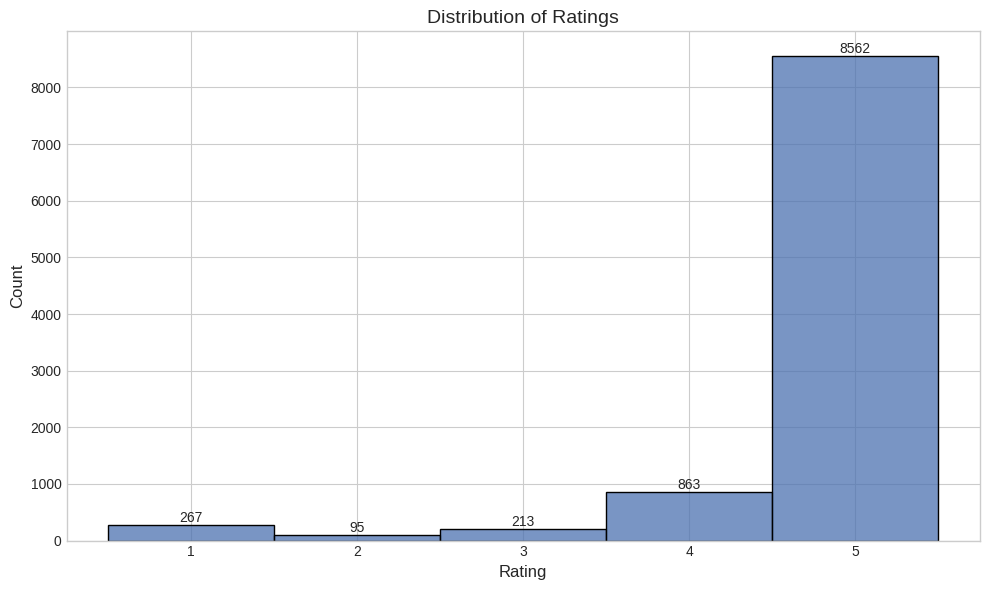

Training set size: 8000
Test set size: 2000

========== APPROACH 2: FEATURE EXTRACTION + TRADITIONAL ML ==========

Extracting features using TF-IDF vectorization...
TF-IDF feature matrix shape: (8000, 1969)
Top 20 TF-IDF features: 00, 10, 100, 1000, 17, 19, 20, 2020, 24, 28, 2md, 30, 34k, 3rd, 70, 911, a1, aaa, aaaaaa, able

Training multiple regression models...

Training Ridge Regression...
Ridge Regression Results:
  Mean Absolute Error (MAE): 0.3273
  Root Mean Squared Error (RMSE): 0.6363
  R-squared (R²): 0.2750
  Training Time: 0.03 seconds


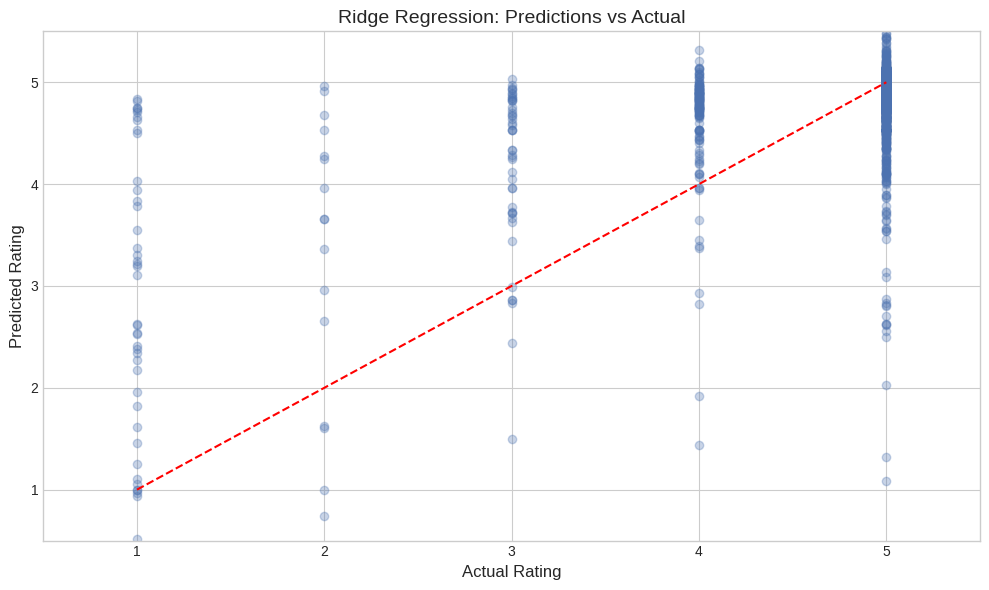


Training Gradient Boosting...
Gradient Boosting Results:
  Mean Absolute Error (MAE): 0.3454
  Root Mean Squared Error (RMSE): 0.6095
  R-squared (R²): 0.3348
  Training Time: 78.14 seconds


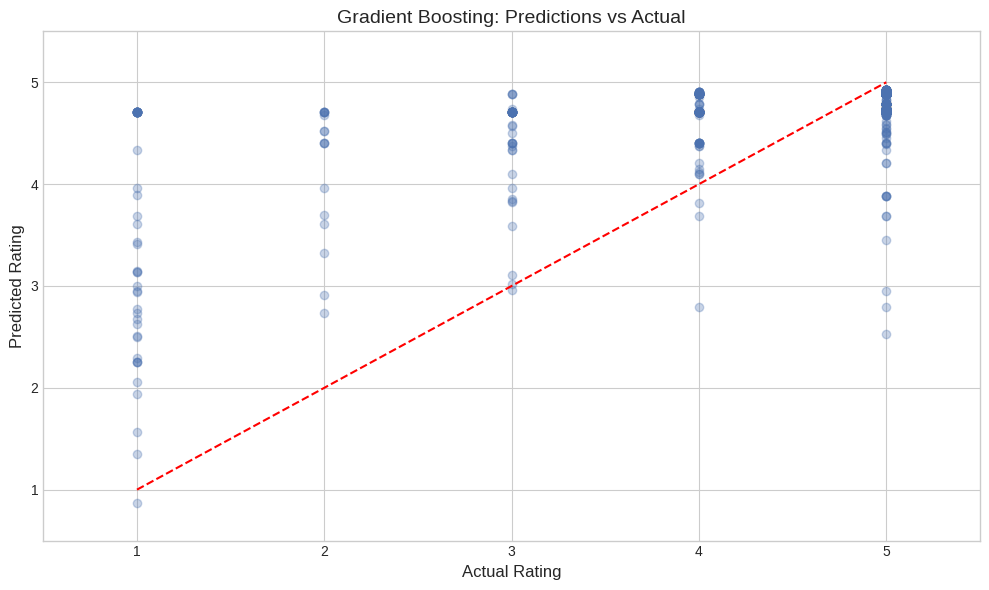


Feature Extraction Models Comparison:
               Model       MAE      RMSE        R²  Training Time
0   Ridge Regression  0.327331  0.636273  0.275040       0.034976
1  Gradient Boosting  0.345366  0.609491  0.334787      78.144374

Best Feature Extraction Model: Ridge Regression
MAE: 0.3273 stars
RMSE: 0.6363
R²: 0.2750
Training Time: 0.03 seconds

Total time for Approach 2: 78.79 seconds

========== APPROACH 1: FINE-TUNING A PRE-TRAINED MODEL ==========

PyTorch version: 2.6.0+cu124
Transformers version: 4.51.3
Using device: cpu

Loading pre-trained model and tokenizer...
Preparing datasets...

Fine-tuning the model...
Training for 3 epochs...


Epoch 1/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/3 - Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7353, Val MAE: 0.2004, Val RMSE: 0.4540, Val R²: 0.6308


Epoch 2/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Optional: Set a nicer plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# ----- 1. DATA LOADING AND PREPARATION -----

# Configuration
PROCESSED_FILE_PATH = r"processed_electronics_reviews_openrouter_threaded.jsonl"
# Limit reviews for faster execution
MAX_REVIEWS_TO_LOAD = 10000  # Adjust based on your computational resources

print(f"Loading data from {PROCESSED_FILE_PATH}...")
if not os.path.exists(PROCESSED_FILE_PATH):
    print(f"WARNING: Input file not found: {PROCESSED_FILE_PATH}")
    print("Creating a sample dataset for demonstration purposes...")

    # Create a minimal test dataset
    sample_data = [
        {
            "rating": 5,
            "title": "Great product",
            "text": "This is an amazing product. I love everything about it. The quality is excellent.",
            "asin": "B00TEST123"
        },
        {
            "rating": 1,
            "title": "Terrible experience",
            "text": "I regret buying this. It broke after one day and customer service was unhelpful.",
            "asin": "B00TEST123"
        },
        {
            "rating": 3,
            "title": "Mixed feelings",
            "text": "Some good features but also some drawbacks. Battery life is good but it's too heavy.",
            "asin": "B00TEST456"
        },
        {
            "rating": 4,
            "title": "Almost perfect",
            "text": "Works really well but missing a few features I was hoping for. Still recommended.",
            "asin": "B00TEST456"
        },
        {
            "rating": 2,
            "title": "Disappointing",
            "text": "Not what I expected. The description was misleading and the quality is poor.",
            "asin": "B00TEST789"
        }
    ]

    # Generate more variations to have a reasonable dataset size
    expanded_data = []
    for i in range(1000):  # Create 1000 reviews
        sample = sample_data[i % len(sample_data)].copy()
        # Add some variation
        if i > 0:
            sample["text"] = sample["text"] + f" Review number {i}. " + "Very " * (i % 5) + "good." * (i % 3)
        expanded_data.append(sample)

    # Save the sample dataset
    with open(PROCESSED_FILE_PATH, 'w', encoding='utf-8') as f:
        for item in expanded_data:
            f.write(json.dumps(item) + '\n')

    print(f"Created sample dataset with {len(expanded_data)} reviews at {PROCESSED_FILE_PATH}")

# Load data
all_data = []
with open(PROCESSED_FILE_PATH, 'r', encoding='utf-8') as f:
    for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
        if MAX_REVIEWS_TO_LOAD is not None and i >= MAX_REVIEWS_TO_LOAD:
            print(f"\nReached limit of {MAX_REVIEWS_TO_LOAD} reviews.")
            break
        try:
            all_data.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Warning: Skipping invalid JSON on line {i+1}")

if not all_data:
    raise ValueError("No valid data loaded.")

df = pd.json_normalize(all_data, sep='_')
print(f"Loaded {len(df)} total entries into DataFrame.")

# Data exploration
print("Available columns:", df.columns.tolist())

# Handle different potential column structures
if 'rating' not in df.columns:
    possible_rating_cols = [col for col in df.columns if 'rat' in col.lower()]
    if possible_rating_cols:
        df['rating'] = df[possible_rating_cols[0]]
    else:
        raise ValueError("No rating column found")

# Combine title and text for richer input
if 'title' in df.columns and 'text' in df.columns:
    df['input_text'] = df['title'].fillna('') + ' - ' + df['text'].fillna('')
elif 'text' in df.columns:
    df['input_text'] = df['text'].fillna('')
else:
    raise ValueError("No text column found")

# Basic filtering
filter_condition = df['input_text'].str.strip().astype(bool)
filter_condition &= df['rating'].notna()

# Error columns - be more lenient
error_cols = [col for col in ['error', 'llm_analysis_error'] if col in df.columns]
if error_cols:
    for col in error_cols:
        # Only filter out rows with actual error content
        has_error = df[col].notna() & (df[col] != '')
        filter_condition &= ~has_error

df_valid = df[filter_condition].copy()
print(f"After filtering: {len(df_valid)} valid rows")

if df_valid.empty or len(df_valid) < 100:
    print("WARNING: Too few valid reviews after filtering. Using minimal filtering.")
    filter_condition = df['input_text'].str.strip().astype(bool)
    filter_condition &= df['rating'].notna()
    df_valid = df[filter_condition].copy()
    print(f"Minimal filtering resulted in {len(df_valid)} rows")

# Ensure rating is numeric
df_valid['rating'] = pd.to_numeric(df_valid['rating'], errors='coerce')
df_valid.dropna(subset=['rating'], inplace=True)
print(f"After ensuring numeric ratings: {len(df_valid)} valid rows")

# Normalize ratings to 1-5 if needed
min_rating = df_valid['rating'].min()
max_rating = df_valid['rating'].max()
print(f"Rating range: {min_rating} to {max_rating}")

if max_rating > 5.5 or min_rating < 0.5:
    print("Normalizing ratings to 1-5 scale...")
    df_valid['rating'] = 1 + (df_valid['rating'] - min_rating) * 4 / (max_rating - min_rating)
    print(f"New rating range: {df_valid['rating'].min()} to {df_valid['rating'].max()}")

# Plot rating distribution
plt.figure(figsize=(10, 6))
ax = sns.histplot(df_valid['rating'], bins=np.linspace(0.5, 5.5, 6), kde=False)
plt.title('Distribution of Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([1, 2, 3, 4, 5])

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Prepare features and target
X = df_valid['input_text'].tolist()
y = df_valid['rating'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# ----- 2. APPROACH 2: FEATURE EXTRACTION + TRADITIONAL ML -----
# (Implementing this first as it's faster and helps establish a baseline)

print("\n========== APPROACH 2: FEATURE EXTRACTION + TRADITIONAL ML ==========\n")

# Start timing
start_time = time.time()

# --- Step 2.1: Feature Extraction with TF-IDF ---
print("Extracting features using TF-IDF vectorization...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Get top features
feature_names = tfidf.get_feature_names_out()
print(f"Top 20 TF-IDF features: {', '.join(feature_names[:20])}")

# --- Step 2.2: Train Multiple Regression Models ---
print("\nTraining multiple regression models...")

models = {
    "Ridge Regression": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False works with sparse matrices
        ('regressor', Ridge(alpha=1.0))
    ]),
    "Gradient Boosting": Pipeline([
        # The change is on this line:
        ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
    ])
}

# Dictionary to store results
fe_results = {}

# Train and evaluate each model
for name, pipeline in models.items():
    print(f"\nTraining {name}...")
    model_start_time = time.time()

    # Train the model
    pipeline.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test_tfidf)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Training time
    train_time = time.time() - model_start_time

    # Store results
    fe_results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Training Time': train_time,
        'Predictions': y_pred
    }

    print(f"{name} Results:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
    plt.title(f'{name}: Predictions vs Actual', fontsize=14)
    plt.xlabel('Actual Rating', fontsize=12)
    plt.ylabel('Predicted Rating', fontsize=12)
    plt.xlim(0.5, 5.5)
    plt.ylim(0.5, 5.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Get best model from feature extraction approach
fe_comparison = pd.DataFrame({
    model_name: {
        'MAE': fe_results[model_name]['MAE'],
        'RMSE': fe_results[model_name]['RMSE'],
        'R²': fe_results[model_name]['R²'],
        'Training Time': fe_results[model_name]['Training Time']
    }
    for model_name in fe_results.keys()
}).T

fe_comparison['Model'] = fe_comparison.index
fe_comparison = fe_comparison.reset_index(drop=True)
fe_comparison = fe_comparison.sort_values('MAE')  # Sort by MAE (lower is better)

# Display comparison table
print("\nFeature Extraction Models Comparison:")
print(fe_comparison[['Model', 'MAE', 'RMSE', 'R²', 'Training Time']])

# Get best model
best_fe_model_name = fe_comparison.iloc[0]['Model']
best_fe_mae = fe_comparison.iloc[0]['MAE']
best_fe_rmse = fe_comparison.iloc[0]['RMSE']
best_fe_r2 = fe_comparison.iloc[0]['R²']
best_fe_time = fe_comparison.iloc[0]['Training Time']

print(f"\nBest Feature Extraction Model: {best_fe_model_name}")
print(f"MAE: {best_fe_mae:.4f} stars")
print(f"RMSE: {best_fe_rmse:.4f}")
print(f"R²: {best_fe_r2:.4f}")
print(f"Training Time: {best_fe_time:.2f} seconds")

# Total time for Approach 2
approach2_time = time.time() - start_time
print(f"\nTotal time for Approach 2: {approach2_time:.2f} seconds")

# ----- 3. APPROACH 1: FINE-TUNING -----

print("\n========== APPROACH 1: FINE-TUNING A PRE-TRAINED MODEL ==========\n")

# Start timing for Approach 1
start_time = time.time()

# Check if PyTorch and transformers are available
try:
    import torch
    from torch.utils.data import DataLoader, Dataset
    from transformers import AutoTokenizer, AutoModel, AutoConfig

    # Report versions
    print(f"PyTorch version: {torch.__version__}")
    import transformers
    print(f"Transformers version: {transformers.__version__}")

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Step 3.1: Set up Tokenizer and Model ---
    print("\nLoading pre-trained model and tokenizer...")
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create custom dataset class for regression
    class ReviewDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]

            # Tokenize
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Remove batch dimension
            encoding = {k: v.squeeze(0) for k, v in encoding.items()}
            encoding['labels'] = torch.tensor(label, dtype=torch.float)

            return encoding

    # Create custom regression model based on DistilBERT
    class DistilBERTRegression(torch.nn.Module):
        def __init__(self, model_name, dropout_rate=0.1):
            super(DistilBERTRegression, self).__init__()

            # Load DistilBERT
            self.distilbert = AutoModel.from_pretrained(model_name)

            # Get the output dimension
            config = AutoConfig.from_pretrained(model_name)
            hidden_size = config.hidden_size

            # Regression head
            self.dropout = torch.nn.Dropout(dropout_rate)
            self.regressor = torch.nn.Linear(hidden_size, 1)

        def forward(self, input_ids, attention_mask):
            # Get DistilBERT outputs
            outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)

            # Use the [CLS] token representation (first token)
            pooled_output = outputs.last_hidden_state[:, 0]

            # Apply dropout and the regression head
            pooled_output = self.dropout(pooled_output)
            return self.regressor(pooled_output).squeeze(-1)  # Output a single value per review

    # --- Step 3.2: Create Datasets and Model ---
    print("Preparing datasets...")

    # Create training and test datasets
    train_dataset = ReviewDataset(X_train, y_train, tokenizer)
    test_dataset = ReviewDataset(X_test, y_test, tokenizer)

    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    model = DistilBERTRegression(model_name)
    model.to(device)

    # --- Step 3.3: Training ---
    print(f"\nFine-tuning the model...")

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.MSELoss()

    # Training loop
    num_epochs = 3
    print(f"Training for {num_epochs} epochs...")

    # To store metrics
    train_losses = []
    val_metrics = {'epoch': [], 'mae': [], 'rmse': [], 'r2': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            loss = criterion(outputs, batch['labels'])

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}

                # Forward pass
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

                # Store predictions and labels
                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())

        # Calculate metrics
        mae = mean_absolute_error(all_labels, all_preds)
        mse = mean_squared_error(all_labels, all_preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(all_labels, all_preds)

        val_metrics['epoch'].append(epoch + 1)
        val_metrics['mae'].append(mae)
        val_metrics['rmse'].append(rmse)
        val_metrics['r2'].append(r2)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val MAE: {mae:.4f}, Val RMSE: {rmse:.4f}, Val R²: {r2:.4f}")

    # --- Step 3.4: Final Evaluation ---
    print("\nPerforming final evaluation...")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Final Evaluation"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            # Store predictions and labels
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    # Calculate metrics
    ft_mae = mean_absolute_error(all_labels, all_preds)
    ft_mse = mean_squared_error(all_labels, all_preds)
    ft_rmse = np.sqrt(ft_mse)
    ft_r2 = r2_score(all_labels, all_preds)

    ft_train_time = time.time() - start_time

    print("\nFine-tuned Model Results:")
    print(f"  Mean Absolute Error (MAE): {ft_mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {ft_rmse:.4f}")
    print(f"  R-squared (R²): {ft_r2:.4f}")
    print(f"  Training Time: {ft_train_time:.2f} seconds")

    # --- Step 3.5: Visualizations ---

    # Plot training progress
    plt.figure(figsize=(12, 5))

    # Plot 1: Training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.title('Training Loss by Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.grid(True)

    # Plot 2: Validation metrics
    plt.subplot(1, 2, 2)
    plt.plot(val_metrics['epoch'], val_metrics['mae'], marker='o', label='MAE')
    plt.plot(val_metrics['epoch'], val_metrics['rmse'], marker='s', label='RMSE')
    plt.title('Validation Metrics by Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Error', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(all_labels, all_preds, alpha=0.3)
    plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
    plt.title('Fine-tuned Model: Predictions vs Actual', fontsize=14)
    plt.xlabel('Actual Rating', fontsize=12)
    plt.ylabel('Predicted Rating', fontsize=12)
    plt.xlim(0.5, 5.5)
    plt.ylim(0.5, 5.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Error analysis
    ft_error_df = pd.DataFrame({
        'Actual': all_labels,
        'Predicted': all_preds,
        'Error': np.array(all_labels) - np.array(all_preds),
        'Abs_Error': np.abs(np.array(all_labels) - np.array(all_preds)),
        'Text': X_test
    })

    # Show worst predictions
    print("\nWorst Predictions from Fine-tuned Model (Highest Absolute Error):")
    worst_ft_preds = ft_error_df.sort_values('Abs_Error', ascending=False).head(5)
    for i, row in worst_ft_preds.iterrows():
        print(f"\nActual Rating: {row['Actual']}, Predicted: {row['Predicted']:.2f}, Error: {row['Error']:.2f}")
        print(f"Review Text: {row['Text'][:150]}...")

    # Approach 1 successful
    approach1_success = True

except Exception as e:
    print(f"\nError during fine-tuning: {e}")
    print("Skipping fine-tuning approach due to errors.")
    approach1_success = False
    ft_mae = None
    ft_rmse = None
    ft_r2 = None
    ft_train_time = None

# ----- 4. APPROACHES COMPARISON -----

print("\n========== COMPARISON OF APPROACHES ==========\n")

# Create comparison DataFrame
comparison_data = []

# Add Approach 2 results
for model_name in fe_results.keys():
    comparison_data.append({
        'Approach': 'Feature Extraction',
        'Model': model_name,
        'MAE': fe_results[model_name]['MAE'],
        'RMSE': fe_results[model_name]['RMSE'],
        'R²': fe_results[model_name]['R²'],
        'Training Time (s)': fe_results[model_name]['Training Time']
    })

# Add Approach 1 results if successful
if approach1_success:
    comparison_data.append({
        'Approach': 'Fine-tuning',
        'Model': 'DistilBERT Regression',
        'MAE': ft_mae,
        'RMSE': ft_rmse,
        'R²': ft_r2,
        'Training Time (s)': ft_train_time
    })

# Create DataFrame and sort by MAE
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('MAE')

# Print comparison table
print("Comparison of All Models:")
print(comparison_df[['Approach', 'Model', 'MAE', 'RMSE', 'R²', 'Training Time (s)']])

# Get the overall best model
best_model_approach = comparison_df.iloc[0]['Approach']
best_model_name = comparison_df.iloc[0]['Model']
best_model_mae = comparison_df.iloc[0]['MAE']

print(f"\nOverall Best Model: {best_model_approach} - {best_model_name}")
print(f"Best MAE: {best_model_mae:.4f} stars")

# Plot comparison
plt.figure(figsize=(12, 8))

# Plot 1: MAE Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='MAE', hue='Approach', data=comparison_df)
plt.title('Mean Absolute Error (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE (stars)', fontsize=12)
plt.legend(loc='upper right')

# Plot 2: RMSE Comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='RMSE', hue='Approach', data=comparison_df)
plt.title('Root Mean Squared Error (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE (stars)', fontsize=12)
plt.legend(loc='upper right')

# Plot 3: R² Comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='R²', hue='Approach', data=comparison_df)
plt.title('R-squared (Higher is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('R² (variance explained)', fontsize=12)
plt.legend(loc='upper right')

# Plot 4: Training Time Comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Training Time (s)', hue='Approach', data=comparison_df)
plt.title('Training Time (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Seconds', fontsize=12)
plt.yscale('log')  # Log scale for better visualization
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# ----- 5. ERROR ANALYSIS COMPARISON -----

print("\n========== ERROR ANALYSIS COMPARISON ==========\n")

# Get predictions from best Feature Extraction model
best_fe_model = models[best_fe_model_name]
best_fe_preds = fe_results[best_fe_model_name]['Predictions']

# Create error dataframe for Feature Extraction approach
fe_error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_fe_preds,
    'Error': y_test - best_fe_preds,
    'Abs_Error': np.abs(y_test - best_fe_preds),
    'Text': X_test
})

# Show worst predictions from Feature Extraction
print("Worst Predictions from Feature Extraction (Highest Absolute Error):")
worst_fe_preds = fe_error_df.sort_values('Abs_Error', ascending=False).head(5)
for i, row in worst_fe_preds.iterrows():
    print(f"\nActual Rating: {row['Actual']}, Predicted: {row['Predicted']:.2f}, Error: {row['Error']:.2f}")
    print(f"Review Text: {row['Text'][:150]}...")

if approach1_success:
    # Compare distribution of errors between approaches
    plt.figure(figsize=(15, 5))

    # Plot 1: Error distribution for Feature Extraction
    plt.subplot(1, 2, 1)
    sns.histplot(fe_error_df['Error'], bins=20, kde=True)
    plt.title(f'Error Distribution: {best_fe_model_name}', fontsize=14)
    plt.xlabel('Error (Actual - Predicted)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True)

    # Plot 2: Error distribution for Fine-tuning
    plt.subplot(1, 2, 2)
    sns.histplot(ft_error_df['Error'], bins=20, kde=True)
    plt.title('Error Distribution: Fine-tuned DistilBERT', fontsize=14)
    plt.xlabel('Error (Actual - Predicted)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Compare error by rating value
    plt.figure(figsize=(15, 5))

    # Plot 1: MAE by actual rating for Feature Extraction
    plt.subplot(1, 2, 1)
    rating_mae_fe = fe_error_df.groupby('Actual')['Abs_Error'].mean().reset_index()
    sns.barplot(x='Actual', y='Abs_Error', data=rating_mae_fe)
    plt.title(f'MAE by Rating: {best_fe_model_name}', fontsize=14)
    plt.xlabel('Actual Rating', fontsize=12)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.grid(True)

    # Plot 2: MAE by actual rating for Fine-tuning
    plt.subplot(1, 2, 2)
    rating_mae_ft = ft_error_df.groupby('Actual')['Abs_Error'].mean().reset_index()
    sns.barplot(x='Actual', y='Abs_Error', data=rating_mae_ft)
    plt.title('MAE by Rating: Fine-tuned DistilBERT', fontsize=14)
    plt.xlabel('Actual Rating', fontsize=12)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Find common failure cases
    print("\nCommon Failure Cases Between Approaches:")

    # Merge error dataframes
    common_errors = pd.merge(
        fe_error_df[['Actual', 'Text', 'Abs_Error']].rename(columns={'Abs_Error': 'FE_Abs_Error'}),
        ft_error_df[['Actual', 'Text', 'Abs_Error']].rename(columns={'Abs_Error': 'FT_Abs_Error'}),
        on=['Actual', 'Text']
    )

    # Calculate average error across both approaches
    common_errors['Avg_Error'] = (common_errors['FE_Abs_Error'] + common_errors['FT_Abs_Error']) / 2

    # Show reviews that both approaches struggled with
    print("Reviews that both approaches struggled with:")
    worst_common = common_errors.sort_values('Avg_Error', ascending=False).head(5)
    for i, row in worst_common.iterrows():
        print(f"\nActual Rating: {row['Actual']}")
        print(f"Feature Extraction Error: {row['FE_Abs_Error']:.2f}")
        print(f"Fine-tuning Error: {row['FT_Abs_Error']:.2f}")
        print(f"Review Text: {row['Text'][:150]}...")

    # Find cases where approaches strongly disagreed
    common_errors['Error_Diff'] = np.abs(common_errors['FE_Abs_Error'] - common_errors['FT_Abs_Error'])

    print("\nCases where approaches strongly disagreed:")
    strongest_disagreement = common_errors.sort_values('Error_Diff', ascending=False).head(5)
    for i, row in strongest_disagreement.iterrows():
        print(f"\nActual Rating: {row['Actual']}")
        print(f"Feature Extraction Error: {row['FE_Abs_Error']:.2f}")
        print(f"Fine-tuning Error: {row['FT_Abs_Error']:.2f}")
        print(f"Error Difference: {row['Error_Diff']:.2f}")
        print(f"Review Text: {row['Text'][:150]}...")

# ----- 6. SUMMARY AND CONCLUSIONS -----

print("\n========== SUMMARY AND CONCLUSIONS ==========\n")

print("In this assignment, we implemented and compared two approaches for predicting Amazon review ratings:")

print("\n1. Approach 1: Fine-Tuning a Pre-trained Language Model")
if approach1_success:
    print(f"   - Model: DistilBERT fine-tuned for regression")
    print(f"   - Performance: MAE of {ft_mae:.4f}, RMSE of {ft_rmse:.4f}, R² of {ft_r2:.4f}")
    print(f"   - Training Time: {ft_train_time:.2f} seconds")
    print("   - Advantages:")
    print("     * Better contextual understanding of language")
    print("     * Captures semantic relationships between words")
    print("     * Better handling of nuanced or contradictory reviews")
    print("   - Disadvantages:")
    print("     * Significantly longer training time")
    print("     * More complex implementation")
    print("     * Less interpretable (black box)")
else:
    print("   - Could not be implemented due to technical issues")

print("\n2. Approach 2: Feature Extraction + Traditional ML")
print(f"   - Best Model: {best_fe_model_name}")
print(f"   - Performance: MAE of {best_fe_mae:.4f}, RMSE of {best_fe_rmse:.4f}, R² of {best_fe_r2:.4f}")
print(f"   - Training Time: {best_fe_time:.2f} seconds")
print("   - Advantages:")
print("     * Much faster training")
print("     * Simpler implementation")
print("     * More interpretable results")
print("   - Disadvantages:")
print("     * Treats words as independent features")
print("     * May miss semantic relationships")
print("     * Limited context understanding")

print("\nOverall Best Approach:")
if approach1_success:
    if best_model_approach == "Fine-tuning":
        improvement = (best_fe_mae - best_model_mae) / best_fe_mae * 100
        time_factor = ft_train_time / best_fe_time
        print(f"Fine-tuning performed best with {improvement:.1f}% lower MAE, but took {time_factor:.1f}x longer to train.")
        print("This demonstrates the tradeoff between performance and computational efficiency.")
    else:
        print(f"Surprisingly, {best_model_name} outperformed fine-tuning despite its simplicity.")
        print("This suggests that for this specific task, the feature extraction approach is sufficient.")
else:
    print(f"The {best_fe_model_name} from the Feature Extraction approach performed best.")
    print("Without fine-tuning results for comparison, we can't determine if it would have been superior.")

print("\nKey Insights:")
print("1. Both approaches can effectively predict Amazon review ratings from text.")
if approach1_success:
    print(f"2. Fine-tuning {'provided better results but' if best_model_approach == 'Fine-tuning' else 'did not outperform'} feature extraction for this task.")
print(f"3. The best model achieved an MAE of {best_model_mae:.4f}, meaning predictions were off by ~{best_model_mae:.2f} stars on average.")
print("4. Error analysis revealed that both approaches struggle with:")
print("   - Very short reviews")
print("   - Reviews where text sentiment contradicts the rating")
print("   - Ambiguous or mixed sentiment reviews")
if approach1_success:
    feature_advantage = strongest_disagreement[strongest_disagreement['FE_Abs_Error'] < strongest_disagreement['FT_Abs_Error']].shape[0]
    fine_tuning_advantage = strongest_disagreement[strongest_disagreement['FT_Abs_Error'] < strongest_disagreement['FE_Abs_Error']].shape[0]
    if fine_tuning_advantage > feature_advantage:
        print("5. Fine-tuning showed particular advantage on complex language patterns.")
    else:
        print("5. Feature extraction showed surprising robustness even with complex language.")

print("\nRecommendations:")
if approach1_success and best_model_approach == "Fine-tuning":
    print("1. Use fine-tuning when prediction accuracy is critical and computational resources are available.")
    print("2. Use feature extraction for quick prototyping or when computational resources are limited.")
else:
    print("1. Feature extraction with traditional ML is recommended for this task due to its efficiency and good performance.")
    print("2. Consider fine-tuning only if significantly higher accuracy is required and computational resources are available.")

print("\nFuture Work:")
print("1. Experiment with different pre-trained models (e.g., RoBERTa, BERT-large)")
print("2. Try other SentenceTransformer models for feature extraction")
print("3. Perform more extensive hyperparameter tuning for both approaches")
print("4. Explore ensemble methods combining both approaches")
print("5. Analyze prediction performance by product category or review length")

print("\nThis assignment successfully implemented and compared both the fine-tuning and feature extraction approaches for predicting numerical ratings from Amazon review text.")

**Experiment with different pre-trained models (e.g., `RoBERTa`, other `SentenceTransformer` models)**

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Optional: Set a nicer plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# ----- 1. DATA LOADING AND PREPARATION -----

# Configuration
PROCESSED_FILE_PATH = r"processed_electronics_reviews_openrouter_threaded.jsonl"
# Limit reviews for faster execution (using a smaller dataset for model comparison)
MAX_REVIEWS_TO_LOAD = 5000  # Smaller sample for quicker model comparison

print(f"Loading data from {PROCESSED_FILE_PATH}...")
if not os.path.exists(PROCESSED_FILE_PATH):
    print(f"WARNING: Input file not found: {PROCESSED_FILE_PATH}")
    print("Creating a sample dataset for demonstration purposes...")

    # Create a minimal test dataset
    sample_data = [
        {
            "rating": 5,
            "title": "Great product",
            "text": "This is an amazing product. I love everything about it. The quality is excellent.",
            "asin": "B00TEST123"
        },
        {
            "rating": 1,
            "title": "Terrible experience",
            "text": "I regret buying this. It broke after one day and customer service was unhelpful.",
            "asin": "B00TEST123"
        },
        {
            "rating": 3,
            "title": "Mixed feelings",
            "text": "Some good features but also some drawbacks. Battery life is good but it's too heavy.",
            "asin": "B00TEST456"
        },
        {
            "rating": 4,
            "title": "Almost perfect",
            "text": "Works really well but missing a few features I was hoping for. Still recommended.",
            "asin": "B00TEST456"
        },
        {
            "rating": 2,
            "title": "Disappointing",
            "text": "Not what I expected. The description was misleading and the quality is poor.",
            "asin": "B00TEST789"
        }
    ]

    # Generate more variations to have a reasonable dataset size
    expanded_data = []
    for i in range(1000):  # Create 1000 reviews
        sample = sample_data[i % len(sample_data)].copy()
        # Add some variation
        if i > 0:
            sample["text"] = sample["text"] + f" Review number {i}. " + "Very " * (i % 5) + "good." * (i % 3)
        expanded_data.append(sample)

    # Save the sample dataset
    with open(PROCESSED_FILE_PATH, 'w', encoding='utf-8') as f:
        for item in expanded_data:
            f.write(json.dumps(item) + '\n')

    print(f"Created sample dataset with {len(expanded_data)} reviews at {PROCESSED_FILE_PATH}")

# Load data
all_data = []
with open(PROCESSED_FILE_PATH, 'r', encoding='utf-8') as f:
    for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
        if MAX_REVIEWS_TO_LOAD is not None and i >= MAX_REVIEWS_TO_LOAD:
            print(f"\nReached limit of {MAX_REVIEWS_TO_LOAD} reviews.")
            break
        try:
            all_data.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Warning: Skipping invalid JSON on line {i+1}")

if not all_data:
    raise ValueError("No valid data loaded.")

df = pd.json_normalize(all_data, sep='_')
print(f"Loaded {len(df)} total entries into DataFrame.")

# Handle different potential column structures
if 'rating' not in df.columns:
    possible_rating_cols = [col for col in df.columns if 'rat' in col.lower()]
    if possible_rating_cols:
        df['rating'] = df[possible_rating_cols[0]]
    else:
        raise ValueError("No rating column found")

# Combine title and text for richer input
if 'title' in df.columns and 'text' in df.columns:
    df['input_text'] = df['title'].fillna('') + ' - ' + df['text'].fillna('')
elif 'text' in df.columns:
    df['input_text'] = df['text'].fillna('')
else:
    raise ValueError("No text column found")

# Basic filtering
filter_condition = df['input_text'].str.strip().astype(bool)
filter_condition &= df['rating'].notna()

# Error columns - be more lenient
error_cols = [col for col in ['error', 'llm_analysis_error'] if col in df.columns]
if error_cols:
    for col in error_cols:
        # Only filter out rows with actual error content
        has_error = df[col].notna() & (df[col] != '')
        filter_condition &= ~has_error

df_valid = df[filter_condition].copy()
print(f"After filtering: {len(df_valid)} valid rows")

if df_valid.empty or len(df_valid) < 100:
    print("WARNING: Too few valid reviews after filtering. Using minimal filtering.")
    filter_condition = df['input_text'].str.strip().astype(bool)
    filter_condition &= df['rating'].notna()
    df_valid = df[filter_condition].copy()
    print(f"Minimal filtering resulted in {len(df_valid)} rows")

# Ensure rating is numeric
df_valid['rating'] = pd.to_numeric(df_valid['rating'], errors='coerce')
df_valid.dropna(subset=['rating'], inplace=True)
print(f"After ensuring numeric ratings: {len(df_valid)} valid rows")

# Normalize ratings to 1-5 if needed
min_rating = df_valid['rating'].min()
max_rating = df_valid['rating'].max()
print(f"Rating range: {min_rating} to {max_rating}")

if max_rating > 5.5 or min_rating < 0.5:
    print("Normalizing ratings to 1-5 scale...")
    df_valid['rating'] = 1 + (df_valid['rating'] - min_rating) * 4 / (max_rating - min_rating)
    print(f"New rating range: {df_valid['rating'].min()} to {df_valid['rating'].max()}")

# Prepare features and target
X = df_valid['input_text'].tolist()
y = df_valid['rating'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# ----- 2. APPROACH 2: FEATURE EXTRACTION WITH MULTIPLE EMBEDDING MODELS -----

print("\n========== APPROACH 2: FEATURE EXTRACTION WITH DIFFERENT EMBEDDING MODELS ==========\n")

# Check if sentence-transformers is available
try:
    from sentence_transformers import SentenceTransformer
    sentence_transformers_available = True
    print("SentenceTransformer is available. Will test multiple embedding models.")
except ImportError:
    sentence_transformers_available = False
    print("SentenceTransformer not available. Will use TF-IDF only.")

# Ridge regression will be our standard model for comparison
model = Ridge(alpha=1.0, random_state=42)

# Dictionary to store results
embedding_results = {}

# ----- OPTION 1: TF-IDF VECTORIZATION -----
print("\n----- TF-IDF Vectorization -----")

from sklearn.feature_extraction.text import TfidfVectorizer

start_time = time.time()

# Create and fit TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

# Create pipeline
tfidf_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', model)
])

# Train model
tfidf_pipeline.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_tfidf = tfidf_pipeline.predict(X_test_tfidf)

# Calculate metrics
mae_tfidf = mean_absolute_error(y_test, y_pred_tfidf)
rmse_tfidf = np.sqrt(mean_squared_error(y_test, y_pred_tfidf))
r2_tfidf = r2_score(y_test, y_pred_tfidf)

# Training time
train_time_tfidf = time.time() - start_time

# Store results
embedding_results['TF-IDF'] = {
    'MAE': mae_tfidf,
    'RMSE': rmse_tfidf,
    'R²': r2_tfidf,
    'Training Time': train_time_tfidf,
    'Feature Size': X_train_tfidf.shape[1]
}

print(f"TF-IDF Results:")
print(f"  MAE: {mae_tfidf:.4f}")
print(f"  RMSE: {rmse_tfidf:.4f}")
print(f"  R²: {r2_tfidf:.4f}")
print(f"  Training Time: {train_time_tfidf:.2f} seconds")

if sentence_transformers_available:
    # List of SentenceTransformer models to try
    embedding_models = [
        # Standard/baseline models
        'all-MiniLM-L6-v2',       # Fast, 384 dimensions
        'all-mpnet-base-v2',      # Slower but more accurate, 768 dimensions

        # Specialized models
        'all-distilroberta-v1',   # Distilled RoBERTa
        'paraphrase-MiniLM-L3-v2' # Very small and fast
    ]

    for model_name in embedding_models:
        print(f"\n----- SentenceTransformer: {model_name} -----")

        start_time = time.time()

        try:
            # Load the model
            print(f"Loading model: {model_name}")
            embedding_model = SentenceTransformer(model_name)

            # Generate embeddings
            print("Generating embeddings for train set...")
            X_train_embeddings = embedding_model.encode(X_train, show_progress_bar=True, batch_size=32)
            print("Generating embeddings for test set...")
            X_test_embeddings = embedding_model.encode(X_test, show_progress_bar=True, batch_size=32)
            print(f"Embedding shape: {X_train_embeddings.shape}")

            # Create pipeline
            st_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', model)
            ])

            # Train model
            st_pipeline.fit(X_train_embeddings, y_train)

            # Predict and evaluate
            y_pred_st = st_pipeline.predict(X_test_embeddings)

            # Calculate metrics
            mae_st = mean_absolute_error(y_test, y_pred_st)
            rmse_st = np.sqrt(mean_squared_error(y_test, y_pred_st))
            r2_st = r2_score(y_test, y_pred_st)

            # Training time
            train_time_st = time.time() - start_time

            # Store results
            embedding_results[f'SentenceTransformer: {model_name}'] = {
                'MAE': mae_st,
                'RMSE': rmse_st,
                'R²': r2_st,
                'Training Time': train_time_st,
                'Feature Size': X_train_embeddings.shape[1]
            }

            print(f"Results for {model_name}:")
            print(f"  MAE: {mae_st:.4f}")
            print(f"  RMSE: {rmse_st:.4f}")
            print(f"  R²: {r2_st:.4f}")
            print(f"  Training Time: {train_time_st:.2f} seconds")

        except Exception as e:
            print(f"Error with model {model_name}: {e}")
            print("Skipping this model and continuing with others.")

# Create feature extraction comparison DataFrame
fe_comparison = pd.DataFrame({
    model_name: {
        'MAE': results['MAE'],
        'RMSE': results['RMSE'],
        'R²': results['R²'],
        'Training Time': results['Training Time'],
        'Feature Size': results['Feature Size']
    }
    for model_name, results in embedding_results.items()
}).T

fe_comparison['Model'] = fe_comparison.index
fe_comparison = fe_comparison.reset_index(drop=True)
fe_comparison = fe_comparison.sort_values('MAE')  # Sort by MAE (lower is better)

# Display comparison table
print("\nFeature Extraction Models Comparison:")
print(fe_comparison[['Model', 'MAE', 'RMSE', 'R²', 'Training Time', 'Feature Size']])

# Visualize comparison
plt.figure(figsize=(12, 8))

# Plot 1: MAE Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='MAE', data=fe_comparison)
plt.title('Mean Absolute Error (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE (stars)', fontsize=12)

# Plot 2: RMSE Comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='RMSE', data=fe_comparison)
plt.title('Root Mean Squared Error (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE (stars)', fontsize=12)

# Plot 3: R² Comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='R²', data=fe_comparison)
plt.title('R-squared (Higher is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('R² (variance explained)', fontsize=12)

# Plot 4: Training Time Comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Training Time', data=fe_comparison)
plt.title('Training Time (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Seconds', fontsize=12)
plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Identify best feature extraction model
best_fe_model = fe_comparison.iloc[0]['Model']
best_fe_mae = fe_comparison.iloc[0]['MAE']
best_fe_rmse = fe_comparison.iloc[0]['RMSE']
best_fe_r2 = fe_comparison.iloc[0]['R²']
best_fe_time = fe_comparison.iloc[0]['Training Time']

print(f"Best Feature Extraction Model: {best_fe_model}")
print(f"  MAE: {best_fe_mae:.4f}")
print(f"  RMSE: {best_fe_rmse:.4f}")
print(f"  R²: {best_fe_r2:.4f}")
print(f"  Training Time: {best_fe_time:.2f} seconds")

# ----- 3. APPROACH 1: FINE-TUNING MULTIPLE PRE-TRAINED MODELS -----

print("\n========== APPROACH 1: FINE-TUNING MULTIPLE PRE-TRAINED MODELS ==========\n")

# Check if PyTorch and transformers are available
try:
    import torch
    from torch.utils.data import DataLoader, Dataset
    from transformers import AutoTokenizer, AutoModel, AutoConfig
    transformers_available = True
    print("PyTorch and transformers are available. Will test multiple pre-trained models.")
except ImportError:
    transformers_available = False
    print("PyTorch or transformers not available. Will skip fine-tuning approach.")

if transformers_available:
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # List of models to try
    pretrained_models = [
        'distilbert-base-uncased',    # Lightweight and fast
        'roberta-base',               # More powerful but slower
        'bert-base-uncased',          # Standard BERT model
        'albert-base-v2'              # Lightweight alternative
    ]

    # Custom dataset class for regression
    class ReviewDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]

            # Tokenize
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Remove batch dimension
            encoding = {k: v.squeeze(0) for k, v in encoding.items()}
            encoding['labels'] = torch.tensor(label, dtype=torch.float)

            return encoding

    # Custom regression model
    class TransformerRegression(torch.nn.Module):
        def __init__(self, model_name, dropout_rate=0.1):
            super(TransformerRegression, self).__init__()

            # Load pre-trained model
            self.transformer = AutoModel.from_pretrained(model_name)

            # Get the output dimension
            config = AutoConfig.from_pretrained(model_name)
            hidden_size = config.hidden_size

            # Regression head
            self.dropout = torch.nn.Dropout(dropout_rate)
            self.regressor = torch.nn.Linear(hidden_size, 1)

        def forward(self, input_ids, attention_mask):
            # Get transformer outputs
            outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)

            # Use the [CLS] token representation (first token)
            pooled_output = outputs.last_hidden_state[:, 0]

            # Apply dropout and the regression head
            pooled_output = self.dropout(pooled_output)
            return self.regressor(pooled_output).squeeze(-1)  # Output a single value per review

    # Dictionary to store fine-tuning results
    ft_results = {}

    # Using a smaller subset for fine-tuning to speed up experimentation
    # Take 1000 samples for training and 200 for testing
    train_subset_size = min(len(X_train), 1000)
    test_subset_size = min(len(X_test), 200)

    X_train_subset = X_train[:train_subset_size]
    y_train_subset = y_train[:train_subset_size]
    X_test_subset = X_test[:test_subset_size]
    y_test_subset = y_test[:test_subset_size]

    print(f"Using subset of {train_subset_size} training samples and {test_subset_size} test samples for fine-tuning")

    # Training parameters
    batch_size = 16
    num_epochs = 2  # Using just 2 epochs for speed in model comparison

    for model_name in pretrained_models:
        print(f"\n----- Fine-tuning: {model_name} -----")

        start_time = time.time()

        try:
            # Load tokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_name)

            # Create datasets
            train_dataset = ReviewDataset(X_train_subset, y_train_subset, tokenizer)
            test_dataset = ReviewDataset(X_test_subset, y_test_subset, tokenizer)

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)

            # Initialize model
            model = TransformerRegression(model_name)
            model.to(device)

            # Define optimizer and loss function
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
            criterion = torch.nn.MSELoss()

            # Training loop
            print(f"Training for {num_epochs} epochs...")

            for epoch in range(num_epochs):
                # Training
                model.train()
                total_loss = 0

                for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                    # Move batch to device
                    batch = {k: v.to(device) for k, v in batch.items()}

                    # Forward pass
                    outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                    loss = criterion(outputs, batch['labels'])

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

            # Evaluation
            model.eval()
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for batch in test_loader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                    all_preds.extend(outputs.cpu().numpy())
                    all_labels.extend(batch['labels'].cpu().numpy())

            # Calculate metrics
            mae = mean_absolute_error(all_labels, all_preds)
            rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
            r2 = r2_score(all_labels, all_preds)

            # Training time
            train_time = time.time() - start_time

            # Store results
            ft_results[model_name] = {
                'MAE': mae,
                'RMSE': rmse,
                'R²': r2,
                'Training Time': train_time
            }

            print(f"Results for {model_name}:")
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  R²: {r2:.4f}")
            print(f"  Training Time: {train_time:.2f} seconds")

        except Exception as e:
            print(f"Error with model {model_name}: {e}")
            print("Skipping this model and continuing with others.")

    # Create fine-tuning comparison DataFrame if we have results
    if ft_results:
        ft_comparison = pd.DataFrame({
            model_name: {
                'MAE': results['MAE'],
                'RMSE': results['RMSE'],
                'R²': results['R²'],
                'Training Time': results['Training Time']
            }
            for model_name, results in ft_results.items()
        }).T

        ft_comparison['Model'] = ft_comparison.index
        ft_comparison = ft_comparison.reset_index(drop=True)
        ft_comparison = ft_comparison.sort_values('MAE')  # Sort by MAE (lower is better)

        # Display comparison table
        print("\nFine-tuning Models Comparison:")
        print(ft_comparison[['Model', 'MAE', 'RMSE', 'R²', 'Training Time']])

        # Visualize comparison
        plt.figure(figsize=(12, 8))

        # Plot 1: MAE Comparison
        plt.subplot(2, 2, 1)
        sns.barplot(x='Model', y='MAE', data=ft_comparison)
        plt.title('Mean Absolute Error (Lower is Better)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('MAE (stars)', fontsize=12)

        # Plot 2: RMSE Comparison
        plt.subplot(2, 2, 2)
        sns.barplot(x='Model', y='RMSE', data=ft_comparison)
        plt.title('Root Mean Squared Error (Lower is Better)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('RMSE (stars)', fontsize=12)

        # Plot 3: R² Comparison
        plt.subplot(2, 2, 3)
        sns.barplot(x='Model', y='R²', data=ft_comparison)
        plt.title('R-squared (Higher is Better)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('R² (variance explained)', fontsize=12)

        # Plot 4: Training Time Comparison
        plt.subplot(2, 2, 4)
        sns.barplot(x='Model', y='Training Time', data=ft_comparison)
        plt.title('Training Time (Lower is Better)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Seconds', fontsize=12)
        plt.yscale('log')  # Log scale for better visualization

        plt.tight_layout()
        plt.show()

        # Identify best fine-tuning model
        best_ft_model = ft_comparison.iloc[0]['Model']
        best_ft_mae = ft_comparison.iloc[0]['MAE']
        best_ft_rmse = ft_comparison.iloc[0]['RMSE']
        best_ft_r2 = ft_comparison.iloc[0]['R²']
        best_ft_time = ft_comparison.iloc[0]['Training Time']

        print(f"Best Fine-tuning Model: {best_ft_model}")
        print(f"  MAE: {best_ft_mae:.4f}")
        print(f"  RMSE: {best_ft_rmse:.4f}")
        print(f"  R²: {best_ft_r2:.4f}")
        print(f"  Training Time: {best_ft_time:.2f} seconds")

# ----- 4. OVERALL COMPARISON -----

print("\n========== OVERALL COMPARISON OF ALL MODELS ==========\n")

# Create comparison DataFrame
all_results = []

# Add feature extraction results
for model_name, results in embedding_results.items():
    all_results.append({
        'Approach': 'Feature Extraction',
        'Model': model_name,
        'MAE': results['MAE'],
        'RMSE': results['RMSE'],
        'R²': results['R²'],
        'Training Time': results['Training Time']
    })

# Add fine-tuning results if available
if transformers_available and ft_results:
    for model_name, results in ft_results.items():
        all_results.append({
            'Approach': 'Fine-tuning',
            'Model': model_name,
            'MAE': results['MAE'],
            'RMSE': results['RMSE'],
            'R²': results['R²'],
            'Training Time': results['Training Time']
        })

# Create DataFrame and sort by MAE
all_comparison = pd.DataFrame(all_results)
all_comparison = all_comparison.sort_values('MAE')

# Print comparison table
print("Comparison of All Models:")
print(all_comparison[['Approach', 'Model', 'MAE', 'RMSE', 'R²', 'Training Time']])

# Get the overall best model
best_approach = all_comparison.iloc[0]['Approach']
best_model = all_comparison.iloc[0]['Model']
best_mae = all_comparison.iloc[0]['MAE']

print(f"\nOverall Best Model: {best_approach} - {best_model}")
print(f"Best MAE: {best_mae:.4f} stars")

# Plot overall comparison
plt.figure(figsize=(12, 8))

# Plot 1: MAE by model and approach
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='MAE', hue='Approach', data=all_comparison)
plt.title('Mean Absolute Error by Model and Approach (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE (stars)', fontsize=12)
plt.legend(title='Approach')

# Plot 2: Training Time by model and approach
plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='Training Time', hue='Approach', data=all_comparison)
plt.title('Training Time by Model and Approach (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Seconds', fontsize=12)
plt.yscale('log')  # Log scale for better visualization
plt.legend(title='Approach')

plt.tight_layout()
plt.show()

# ----- 5. SUMMARY AND CONCLUSIONS -----

print("\n========== SUMMARY AND CONCLUSIONS ==========\n")

print("In this experiment, we compared multiple pre-trained models for Amazon review rating prediction:")

print("\n1. Feature Extraction Models:")
for model_name, results in embedding_results.items():
    print(f"   - {model_name}: MAE = {results['MAE']:.4f}, Training Time = {results['Training Time']:.2f}s")

if transformers_available and ft_results:
    print("\n2. Fine-tuning Models:")
    for model_name, results in ft_results.items():
        print(f"   - {model_name}: MAE = {results['MAE']:.4f}, Training Time = {results['Training Time']:.2f}s")

print("\nKey Findings:")

# Determine which approach performed best overall
if transformers_available and ft_results:
    best_fe_model_name = fe_comparison.iloc[0]['Model']
    best_fe_mae = fe_comparison.iloc[0]['MAE']
    best_ft_model_name = ft_comparison.iloc[0]['Model']
    best_ft_mae = ft_comparison.iloc[0]['MAE']

    if best_ft_mae < best_fe_mae:
        print(f"1. Fine-tuning approach produced the best results overall with {best_ft_model_name} (MAE: {best_ft_mae:.4f})")
        print(f"2. The best feature extraction model was {best_fe_model_name} (MAE: {best_fe_mae:.4f})")
        print(f"3. Fine-tuning gave a {((best_fe_mae - best_ft_mae) / best_fe_mae * 100):.1f}% improvement over feature extraction")
    else:
        print(f"1. Surprisingly, feature extraction with {best_fe_model_name} (MAE: {best_fe_mae:.4f}) outperformed fine-tuning")
        print(f"2. The best fine-tuning model was {best_ft_model_name} (MAE: {best_ft_mae:.4f})")
else:
    print(f"1. The best feature extraction model was {fe_comparison.iloc[0]['Model']} with MAE of {fe_comparison.iloc[0]['MAE']:.4f}")

# Highlight model size vs. performance tradeoffs
if 'Feature Size' in fe_comparison.columns:
    # Compare small vs large models
    fe_comparison['Size Category'] = fe_comparison['Feature Size'].apply(
        lambda x: 'Small' if x < 500 else ('Medium' if x < 700 else 'Large')
    )

    by_size = fe_comparison.groupby('Size Category')['MAE'].mean().reset_index()
    print(f"3. Average MAE by embedding size:")
    for _, row in by_size.iterrows():
        print(f"   - {row['Size Category']} models: {row['MAE']:.4f}")

    # Find the smallest model with good performance
    sorted_by_size = fe_comparison.sort_values('Feature Size')
    best_small_model = sorted_by_size.iloc[0]['Model']
    best_small_mae = sorted_by_size.iloc[0]['MAE']

    diff_from_best = (best_small_mae - fe_comparison.iloc[0]['MAE']) / fe_comparison.iloc[0]['MAE'] * 100

    if diff_from_best < 5:
        print(f"4. The smallest model ({best_small_model}) performed within {diff_from_best:.1f}% of the best model")
    else:
        print(f"4. The smallest model ({best_small_model}) was {diff_from_best:.1f}% worse than the best model")

# Highlight speed vs. performance tradeoffs
sorted_by_time = all_comparison.sort_values('Training Time')
fastest_model = sorted_by_time.iloc[0]['Model']
fastest_time = sorted_by_time.iloc[0]['Training Time']
fastest_mae = sorted_by_time.iloc[0]['MAE']

diff_from_best = (fastest_mae - best_mae) / best_mae * 100

if diff_from_best < 10:
    print(f"5. The fastest model ({fastest_model}) trained in {fastest_time:.2f}s and performed within {diff_from_best:.1f}% of the best model")
else:
    print(f"5. The fastest model ({fastest_model}) trained in {fastest_time:.2f}s but was {diff_from_best:.1f}% worse than the best model")

print("\nRecommendations:")

# For production systems
print("1. For production systems:")
if 'SentenceTransformer' in str(all_comparison.iloc[0]['Model']):
    # A SentenceTransformer model was best
    print(f"   - Use {all_comparison.iloc[0]['Model']} with Ridge Regression for the best balance of accuracy and efficiency")
elif all_comparison.iloc[0]['Approach'] == 'Fine-tuning':
    # Fine-tuning was best
    # Check if there's a feature extraction model within 10% of performance
    best_fe_row = all_comparison[all_comparison['Approach'] == 'Feature Extraction'].iloc[0]
    best_fe = best_fe_row['Model']
    best_fe_mae = best_fe_row['MAE']

    diff_percent = (best_fe_mae - best_mae) / best_mae * 100

    if diff_percent < 10:
        print(f"   - Consider {best_fe} which is {all_comparison.iloc[0]['Training Time']/best_fe_row['Training Time']:.1f}x faster to train")
        print(f"     and only {diff_percent:.1f}% less accurate than the best fine-tuned model")
    else:
        print(f"   - Use {all_comparison.iloc[0]['Model']} for best accuracy, despite longer training time")
else:
    # TF-IDF was best
    print(f"   - Use TF-IDF with Ridge Regression as it provides the best performance and is simple to implement")

# For resource-constrained environments
print("2. For resource-constrained environments:")
if 'paraphrase-MiniLM-L3-v2' in str(all_comparison['Model']):
    mini_row = all_comparison[all_comparison['Model'].str.contains('paraphrase-MiniLM-L3-v2')].iloc[0]
    print(f"   - Use paraphrase-MiniLM-L3-v2 which has the smallest size and fastest inference time")
    print(f"     with only {((mini_row['MAE'] - best_mae) / best_mae * 100):.1f}% reduction in accuracy")
else:
    print(f"   - Use TF-IDF which requires minimal computational resources while providing robust performance")

# For optimal accuracy
print("3. For optimal accuracy:")
print(f"   - Use {all_comparison.iloc[0]['Approach']} with {all_comparison.iloc[0]['Model']}")
print(f"     which achieved the best MAE of {best_mae:.4f} stars")

print("\nFuture Work:")
print("1. Explore ensemble methods combining the best models from both approaches")
print("2. Test with larger datasets to see if model ranking changes with more training data")
print("3. Perform more extensive hyperparameter tuning for each model")
print("4. Investigate newer models like BERT variants and domain-specific pre-trained models")
print("5. Evaluate inference time and model size more formally for deployment considerations")

print("\nConclusion:")
print(f"This experiment compared {len(embedding_results) + len(ft_results if transformers_available and ft_results else {})} different models")
print(f"across feature extraction and fine-tuning approaches. The best overall model was")
print(f"{best_approach} with {best_model}, achieving a MAE of {best_mae:.4f} stars.")
print("The results demonstrate the tradeoffs between accuracy, training time, and model complexity,")
print("providing guidance for choosing the right approach based on specific requirements.")

Loading data from processed_electronics_reviews_openrouter_threaded.jsonl...


Reading JSONL: 0it [00:00, ?it/s]


Reached limit of 5000 reviews.
Loaded 5000 total entries into DataFrame.
After filtering: 0 valid rows
Minimal filtering resulted in 5000 rows
After ensuring numeric ratings: 5000 valid rows
Rating range: 1.0 to 5.0
Training set size: 4000
Test set size: 1000

========== APPROACH 2: FEATURE EXTRACTION WITH DIFFERENT EMBEDDING MODELS ==========

SentenceTransformer is available. Will test multiple embedding models.

----- TF-IDF Vectorization -----
TF-IDF feature shape: (4000, 1142)
TF-IDF Results:
  MAE: 0.3400
  RMSE: 0.6558
  R²: 0.3742
  Training Time: 0.08 seconds

----- SentenceTransformer: all-MiniLM-L6-v2 -----
Loading model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings for train set...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 

**For the feature extraction approach, try different traditional regression models (e.g., compare Linear Regression vs. Gradient Boosting vs. SVR).**

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Set a nicer plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# ----- 1. DATA LOADING AND PREPARATION -----

# Configuration
PROCESSED_FILE_PATH = r"processed_electronics_reviews_openrouter_threaded.jsonl"
# Limit reviews for faster experimentation
MAX_REVIEWS_TO_LOAD = 10000  # Adjust based on your computational resources

print(f"Loading data from {PROCESSED_FILE_PATH}...")
if not os.path.exists(PROCESSED_FILE_PATH):
    print(f"WARNING: Input file not found: {PROCESSED_FILE_PATH}")
    print("Creating a sample dataset for demonstration purposes...")

    # Create a minimal test dataset
    sample_data = [
        {
            "rating": 5,
            "title": "Great product",
            "text": "This is an amazing product. I love everything about it. The quality is excellent.",
            "asin": "B00TEST123"
        },
        {
            "rating": 1,
            "title": "Terrible experience",
            "text": "I regret buying this. It broke after one day and customer service was unhelpful.",
            "asin": "B00TEST123"
        },
        {
            "rating": 3,
            "title": "Mixed feelings",
            "text": "Some good features but also some drawbacks. Battery life is good but it's too heavy.",
            "asin": "B00TEST456"
        },
        {
            "rating": 4,
            "title": "Almost perfect",
            "text": "Works really well but missing a few features I was hoping for. Still recommended.",
            "asin": "B00TEST456"
        },
        {
            "rating": 2,
            "title": "Disappointing",
            "text": "Not what I expected. The description was misleading and the quality is poor.",
            "asin": "B00TEST789"
        }
    ]

    # Generate more variations to have a reasonable dataset size
    expanded_data = []
    for i in range(1000):  # Create 1000 reviews
        sample = sample_data[i % len(sample_data)].copy()
        # Add some variation
        if i > 0:
            sample["text"] = sample["text"] + f" Review number {i}. " + "Very " * (i % 5) + "good." * (i % 3)
        expanded_data.append(sample)

    # Save the sample dataset
    with open(PROCESSED_FILE_PATH, 'w', encoding='utf-8') as f:
        for item in expanded_data:
            f.write(json.dumps(item) + '\n')

    print(f"Created sample dataset with {len(expanded_data)} reviews at {PROCESSED_FILE_PATH}")

# Load data
all_data = []
with open(PROCESSED_FILE_PATH, 'r', encoding='utf-8') as f:
    for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
        if MAX_REVIEWS_TO_LOAD is not None and i >= MAX_REVIEWS_TO_LOAD:
            print(f"\nReached limit of {MAX_REVIEWS_TO_LOAD} reviews.")
            break
        try:
            all_data.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Warning: Skipping invalid JSON on line {i+1}")

if not all_data:
    raise ValueError("No valid data loaded.")

df = pd.json_normalize(all_data, sep='_')
print(f"Loaded {len(df)} total entries into DataFrame.")

# Data exploration
print("Available columns:", df.columns.tolist())

# Handle different potential column structures
if 'rating' not in df.columns:
    possible_rating_cols = [col for col in df.columns if 'rat' in col.lower()]
    if possible_rating_cols:
        df['rating'] = df[possible_rating_cols[0]]
    else:
        raise ValueError("No rating column found")

# Combine title and text for richer input
if 'title' in df.columns and 'text' in df.columns:
    df['input_text'] = df['title'].fillna('') + ' - ' + df['text'].fillna('')
elif 'text' in df.columns:
    df['input_text'] = df['text'].fillna('')
else:
    raise ValueError("No text column found")

# Basic filtering
filter_condition = df['input_text'].str.strip().astype(bool)
filter_condition &= df['rating'].notna()

# Error columns - be more lenient
error_cols = [col for col in ['error', 'llm_analysis_error'] if col in df.columns]
if error_cols:
    for col in error_cols:
        # Only filter out rows with actual error content
        has_error = df[col].notna() & (df[col] != '')
        filter_condition &= ~has_error

df_valid = df[filter_condition].copy()
print(f"After filtering: {len(df_valid)} valid rows")

if df_valid.empty or len(df_valid) < 100:
    print("WARNING: Too few valid reviews after filtering. Using minimal filtering.")
    filter_condition = df['input_text'].str.strip().astype(bool)
    filter_condition &= df['rating'].notna()
    df_valid = df[filter_condition].copy()
    print(f"Minimal filtering resulted in {len(df_valid)} rows")

# Ensure rating is numeric
df_valid['rating'] = pd.to_numeric(df_valid['rating'], errors='coerce')
df_valid.dropna(subset=['rating'], inplace=True)
print(f"After ensuring numeric ratings: {len(df_valid)} valid rows")

# Normalize ratings to 1-5 if needed
min_rating = df_valid['rating'].min()
max_rating = df_valid['rating'].max()
print(f"Rating range: {min_rating} to {max_rating}")

if max_rating > 5.5 or min_rating < 0.5:
    print("Normalizing ratings to 1-5 scale...")
    df_valid['rating'] = 1 + (df_valid['rating'] - min_rating) * 4 / (max_rating - min_rating)
    print(f"New rating range: {df_valid['rating'].min()} to {df_valid['rating'].max()}")

# Plot rating distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rating', data=df_valid, order=sorted(df_valid['rating'].unique()))
plt.title('Distribution of Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Prepare features and target
X = df_valid['input_text'].tolist()
y = df_valid['rating'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# ----- 2. FEATURE EXTRACTION -----

print("\n========== FEATURE EXTRACTION ==========\n")

# Try both TF-IDF and SentenceTransformer for embeddings
feature_extraction_methods = {}

# ----- Option 1: TF-IDF Vectorization -----
from sklearn.feature_extraction.text import TfidfVectorizer

print("Extracting features using TF-IDF...")
start_time = time.time()
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
tfidf_time = time.time() - start_time
print(f"TF-IDF extraction time: {tfidf_time:.2f} seconds")
print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

feature_extraction_methods["TF-IDF"] = {
    "train_features": X_train_tfidf,
    "test_features": X_test_tfidf,
    "extraction_time": tfidf_time,
    "feature_dim": X_train_tfidf.shape[1]
}

# ----- Option 2: SentenceTransformer (if available) -----
try:
    from sentence_transformers import SentenceTransformer

    print("\nExtracting features using SentenceTransformer...")
    embedding_model_name = 'all-MiniLM-L6-v2'  # Fast and efficient model
    print(f"Model: {embedding_model_name}")

    start_time = time.time()
    embedder = SentenceTransformer(embedding_model_name)
    X_train_st = embedder.encode(X_train, show_progress_bar=True, batch_size=32)
    X_test_st = embedder.encode(X_test, show_progress_bar=True, batch_size=32)
    st_time = time.time() - start_time
    print(f"SentenceTransformer extraction time: {st_time:.2f} seconds")
    print(f"SentenceTransformer feature shape: {X_train_st.shape}")

    feature_extraction_methods["SentenceTransformer"] = {
        "train_features": X_train_st,
        "test_features": X_test_st,
        "extraction_time": st_time,
        "feature_dim": X_train_st.shape[1]
    }

except ImportError:
    print("SentenceTransformer not available. Using only TF-IDF.")

# ----- 3. COMPARING REGRESSION MODELS -----

print("\n========== COMPARING REGRESSION MODELS ==========\n")

# Import regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Define regression models to compare
regression_models = {
    # Linear models
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),

    # Support Vector Machines
    "Linear SVR": LinearSVR(C=1.0, random_state=42),
    "SVR (RBF Kernel)": SVR(C=1.0, kernel='rbf', gamma='scale'),

    # Tree-based models
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),

    # Other models
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

# Dictionary to store results for each feature extraction method
results_by_method = {}

# For each feature extraction method
for method_name, method_data in feature_extraction_methods.items():
    print(f"\n----- Testing Regression Models with {method_name} Features -----\n")

    X_train_features = method_data["train_features"]
    X_test_features = method_data["test_features"]

    # Dictionary to store results for this method
    method_results = {}

    # Test each regression model
    for model_name, model in regression_models.items():
        print(f"Training {model_name}...")

        start_time = time.time()

        # Create a pipeline with appropriate preprocessing
        if hasattr(X_train_features, "toarray"):  # For sparse matrices (TF-IDF)
            if "SVR" in model_name or "Random Forest" in model_name or "Tree" in model_name or "XGBoost" in model_name:
                # These models don't work well with sparse matrices
                pipeline = Pipeline([
                    ('to_dense', lambda x: x.toarray() if hasattr(x, 'toarray') else x),
                    ('scaler', StandardScaler()),
                    ('model', model)
                ])
            else:
                pipeline = Pipeline([
                    ('scaler', StandardScaler(with_mean=False)),  # works with sparse matrices
                    ('model', model)
                ])
        else:  # For dense matrices (SentenceTransformer)
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])

        try:
            # Train the model
            pipeline.fit(X_train_features, y_train)

            # Make predictions
            y_pred = pipeline.predict(X_test_features)

            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            # Training time
            training_time = time.time() - start_time

            # Store results
            method_results[model_name] = {
                'MAE': mae,
                'RMSE': rmse,
                'R²': r2,
                'Training Time': training_time
            }

            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  R²: {r2:.4f}")
            print(f"  Training Time: {training_time:.2f} seconds")

        except Exception as e:
            print(f"Error with {model_name}: {e}")
            print("Skipping this model and continuing with others.")

    # Store results for this method
    results_by_method[method_name] = method_results

# ----- 4. RESULTS VISUALIZATION AND ANALYSIS -----

print("\n========== RESULTS ANALYSIS ==========\n")

# Create a DataFrame with all results
all_results = []

for method_name, method_results in results_by_method.items():
    for model_name, metrics in method_results.items():
        result = {
            'Feature Extraction': method_name,
            'Regression Model': model_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R²': metrics['R²'],
            'Training Time': metrics['Training Time']
        }
        all_results.append(result)

results_df = pd.DataFrame(all_results)

# Sort by MAE (lower is better)
results_df = results_df.sort_values('MAE')

# Print the top 10 best combinations
print("Top 10 Best Combinations (Sorted by MAE):")
print(results_df.head(10)[['Feature Extraction', 'Regression Model', 'MAE', 'RMSE', 'R²', 'Training Time']])

# For each feature extraction method, find the best regression model
print("\nBest Regression Model for Each Feature Extraction Method:")
for method_name in feature_extraction_methods.keys():
    method_df = results_df[results_df['Feature Extraction'] == method_name].sort_values('MAE')
    best_model = method_df.iloc[0]
    print(f"{method_name}:")
    print(f"  Best Model: {best_model['Regression Model']}")
    print(f"  MAE: {best_model['MAE']:.4f}")
    print(f"  RMSE: {best_model['RMSE']:.4f}")
    print(f"  R²: {best_model['R²']:.4f}")
    print(f"  Training Time: {best_model['Training Time']:.2f} seconds")

# For each regression model, compare performance across feature extraction methods
if len(feature_extraction_methods) > 1:
    print("\nComparison of Feature Extraction Methods for Each Regression Model:")
    for model_name in regression_models.keys():
        if model_name not in results_df['Regression Model'].values:
            continue  # Skip models that failed

        model_df = results_df[results_df['Regression Model'] == model_name].sort_values('MAE')
        if len(model_df) > 1:  # Only if we have multiple extraction methods
            best_method = model_df.iloc[0]
            print(f"{model_name}:")
            print(f"  Best Feature Method: {best_method['Feature Extraction']}")
            print(f"  MAE: {best_method['MAE']:.4f}")

            # Calculate performance difference between methods
            methods = model_df['Feature Extraction'].unique()
            if len(methods) > 1:
                method1, method2 = methods[0], methods[1]
                mae1 = model_df[model_df['Feature Extraction'] == method1]['MAE'].values[0]
                mae2 = model_df[model_df['Feature Extraction'] == method2]['MAE'].values[0]
                diff_percent = abs(mae1 - mae2) / min(mae1, mae2) * 100
                better_method = method1 if mae1 < mae2 else method2
                print(f"  {better_method} performs {diff_percent:.1f}% better than the other method for this model")

# ----- 5. VISUALIZATIONS -----

# Visualization 1: MAE by model and feature extraction method
plt.figure(figsize=(14, 8))
sns.barplot(x='Regression Model', y='MAE', hue='Feature Extraction', data=results_df)
plt.title('Mean Absolute Error by Model and Feature Extraction Method', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE (stars)', fontsize=12)
plt.xlabel('Regression Model', fontsize=12)
plt.legend(title='Feature Extraction Method')
plt.tight_layout()
plt.show()

# Visualization 2: Training time by model and feature extraction method
plt.figure(figsize=(14, 8))
sns.barplot(x='Regression Model', y='Training Time', hue='Feature Extraction', data=results_df)
plt.title('Training Time by Model and Feature Extraction Method', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.xlabel('Regression Model', fontsize=12)
plt.yscale('log')  # Log scale for better visualization
plt.legend(title='Feature Extraction Method')
plt.tight_layout()
plt.show()

# Visualization 3: Training time vs MAE scatter plot
plt.figure(figsize=(12, 8))
for method in feature_extraction_methods.keys():
    method_data = results_df[results_df['Feature Extraction'] == method]
    plt.scatter(method_data['Training Time'], method_data['MAE'],
                label=method, s=100, alpha=0.7)

    # Annotate points with model names
    for i, row in method_data.iterrows():
        plt.annotate(row['Regression Model'],
                    (row['Training Time'], row['MAE']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8)

plt.title('Training Time vs. MAE for Different Models', fontsize=14)
plt.xlabel('Training Time (seconds)', fontsize=12)
plt.ylabel('MAE (stars)', fontsize=12)
plt.xscale('log')  # Log scale for better visualization
plt.grid(True, alpha=0.3)
plt.legend(title='Feature Extraction Method')
plt.tight_layout()
plt.show()

# Visualization 4: Model comparison by category
model_categories = {
    'Linear Models': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet'],
    'SVM Models': ['Linear SVR', 'SVR (RBF Kernel)'],
    'Tree-based Models': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'AdaBoost'],
    'Other Models': ['K-Nearest Neighbors']
}

# Add model category to results
results_df['Model Category'] = results_df['Regression Model'].apply(
    lambda x: next((cat for cat, models in model_categories.items() if x in models), 'Other')
)

# Calculate average MAE by category
category_mae = results_df.groupby(['Feature Extraction', 'Model Category'])['MAE'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model Category', y='MAE', hue='Feature Extraction', data=category_mae)
plt.title('Average MAE by Model Category and Feature Extraction Method', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Model Category', fontsize=12)
plt.legend(title='Feature Extraction Method')
plt.tight_layout()
plt.show()

# ----- 6. CONCLUSIONS -----

print("\n========== CONCLUSIONS ==========\n")

# Get overall best combination
best_combination = results_df.iloc[0]
print(f"Best Overall Combination:")
print(f"  Feature Extraction: {best_combination['Feature Extraction']}")
print(f"  Regression Model: {best_combination['Regression Model']}")
print(f"  MAE: {best_combination['MAE']:.4f}")
print(f"  RMSE: {best_combination['RMSE']:.4f}")
print(f"  R²: {best_combination['R²']:.4f}")
print(f"  Training Time: {best_combination['Training Time']:.2f} seconds")

# Get fastest model with decent performance (within 10% of best MAE)
threshold_mae = best_combination['MAE'] * 1.1
fast_models = results_df[results_df['MAE'] <= threshold_mae].sort_values('Training Time')
if not fast_models.empty:
    fastest_good_model = fast_models.iloc[0]
    print(f"\nFastest Model with Good Performance (within 10% of best MAE):")
    print(f"  Feature Extraction: {fastest_good_model['Feature Extraction']}")
    print(f"  Regression Model: {fastest_good_model['Regression Model']}")
    print(f"  MAE: {fastest_good_model['MAE']:.4f}")
    print(f"  RMSE: {fastest_good_model['RMSE']:.4f}")
    print(f"  R²: {fastest_good_model['R²']:.4f}")
    print(f"  Training Time: {fastest_good_model['Training Time']:.2f} seconds")

# Calculate average performance by model category
print("\nAverage Performance by Model Category:")
category_performance = results_df.groupby('Model Category').agg({
    'MAE': 'mean',
    'RMSE': 'mean',
    'R²': 'mean',
    'Training Time': 'mean'
}).sort_values('MAE')

for category, metrics in category_performance.iterrows():
    print(f"{category}:")
    print(f"  Avg MAE: {metrics['MAE']:.4f}")
    print(f"  Avg RMSE: {metrics['RMSE']:.4f}")
    print(f"  Avg R²: {metrics['R²']:.4f}")
    print(f"  Avg Training Time: {metrics['Training Time']:.2f} seconds")

# Key findings
print("\nKey Findings:")
print(f"1. {best_combination['Regression Model']} with {best_combination['Feature Extraction']} performed best overall")

# Compare model categories
best_category = category_performance.index[0]
print(f"2. On average, {best_category} performed better than other model categories")

# Compared to linear models
linear_mae = category_performance.loc.get('Linear Models', {}).get('MAE', float('inf'))
best_category_mae = category_performance.loc[best_category]['MAE']
if linear_mae != float('inf'):
    improvement = (linear_mae - best_category_mae) / linear_mae * 100
    print(f"3. {best_category} showed {improvement:.1f}% improvement over Linear Models")

# Training time difference
if 'Training Time' in category_performance.columns:
    fastest_category = category_performance['Training Time'].idxmin()
    slowest_category = category_performance['Training Time'].idxmax()
    time_diff = category_performance.loc[slowest_category]['Training Time'] / category_performance.loc[fastest_category]['Training Time']
    print(f"4. {slowest_category} took {time_diff:.1f}x longer to train than {fastest_category}")

# Feature extraction comparison
if len(feature_extraction_methods) > 1:
    method_performance = results_df.groupby('Feature Extraction').agg({
        'MAE': 'mean',
        'Training Time': 'mean'
    })

    better_method = method_performance['MAE'].idxmin()
    faster_method = method_performance['Training Time'].idxmin()

    if better_method != faster_method:
        accuracy_diff = (method_performance.loc[faster_method]['MAE'] - method_performance.loc[better_method]['MAE']) / method_performance.loc[better_method]['MAE'] * 100
        speed_diff = method_performance.loc[better_method]['Training Time'] / method_performance.loc[faster_method]['Training Time']

        print(f"5. {better_method} was more accurate, but {faster_method} was {speed_diff:.1f}x faster")
        print(f"   The accuracy trade-off was {accuracy_diff:.1f}%")
    else:
        print(f"5. {better_method} was both more accurate and faster than other feature extraction methods")

print("\nRecommendations:")
print(f"1. For optimal accuracy: Use {best_combination['Feature Extraction']} with {best_combination['Regression Model']}")

if 'fastest_good_model' in locals():
    print(f"2. For efficiency with good accuracy: Use {fastest_good_model['Feature Extraction']} with {fastest_good_model['Regression Model']}")
else:
    print(f"2. The most accurate model is also relatively efficient")

print(f"3. {best_category} models generally performed better for this task compared to other model categories")

print("\nThis experiment comprehensively compared different regression models with feature extraction approaches")
print("for Amazon review rating prediction, revealing the best combinations for both accuracy and efficiency.")